<a href="https://colab.research.google.com/github/RenanNB360/Visao_Computacional_Colab/blob/main/GANS_Rede_Adversariais_Generativas/GANS_rede_adversariais_generativas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importações das bibliotecas

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
tf.__version__

'2.12.0'

# Carregamento e pré-processamento da base de dados

In [ ]:
(X_treinamento, y_treinamento), (_,_) = tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 2s 0us/step


In [ ]:
X_treinamento.shape

(60000, 28, 28)

In [ ]:
28 * 28

784

In [ ]:
y_treinamento.shape

(60000,)

1


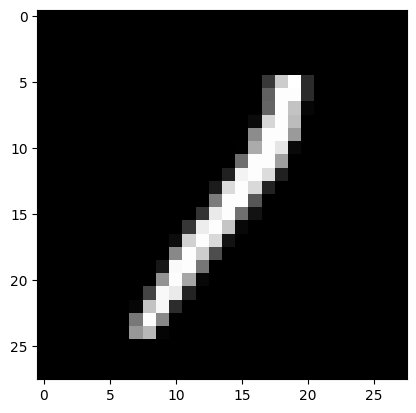

In [ ]:
i = np.random.randint(0 , 60000)
print(y_treinamento[i])
plt.imshow(X_treinamento[i], cmap='gray')

In [ ]:
X_treinamento = X_treinamento.reshape(X_treinamento.shape[0], 28, 28, 1).astype('float32')

In [ ]:
X_treinamento.shape

(60000, 28, 28, 1)

In [ ]:
X_treinamento[0].min(), X_treinamento[0].max()

(0.0, 255.0)

In [ ]:
X_treinamento = (X_treinamento - 127.5) / 127.5

In [ ]:
X_treinamento[0].min(), X_treinamento[0].max()

(-1.0, 1.0)

In [ ]:
buffer_size = 60000
batch_size = 256 # mini batch gradient descent

In [ ]:
buffer_size / batch_size

234.375

In [ ]:
type(X_treinamento)

numpy.ndarray

In [ ]:
X_treinamento = tf.data.Dataset.from_tensor_slices(X_treinamento).shuffle(buffer_size).batch(batch_size)

In [ ]:
type(X_treinamento)

tensorflow.python.data.ops.batch_op._BatchDataset

In [ ]:
X_treinamento

<_BatchDataset element_spec=TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)>

# Construção do Gerador

In [ ]:
def cria_gerador():
  network = tf.keras.Sequential()
  network.add(layers.Dense((7*7*256), use_bias = False, input_shape = (100,)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Reshape((7,7,256)))

  network.add(layers.Conv2DTranspose(128, (5,5), padding='same', use_bias=False))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Conv2DTranspose(64, (5,5), padding='same', use_bias=False, strides=(2,2)))
  network.add(layers.BatchNormalization())
  network.add(layers.LeakyReLU())

  network.add(layers.Conv2DTranspose(1, (5,5), padding='same', use_bias=False, strides=(2,2), activation='tanh'))

  network.summary()

  return network

In [ ]:
gerador = cria_gerador()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 12544)             1254400   
                                                                 
 batch_normalization (BatchN  (None, 12544)            50176     
 ormalization)                                                   
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 12544)             0         
                                                                 
 reshape (Reshape)           (None, 7, 7, 256)         0         
                                                                 
 conv2d_transpose (Conv2DTra  (None, 7, 7, 128)        819200    
 nspose)                                                         
                                                                 
 batch_normalization_1 (Batc  (None, 7, 7, 128)        5

In [ ]:
gerador.input

<KerasTensor: shape=(None, 100) dtype=float32 (created by layer 'dense_input')>

Testando o gerador

In [ ]:
ruido = tf.random.normal([1, 100])
ruido

<tf.Tensor: shape=(1, 100), dtype=float32, numpy=
array([[ 9.70819369e-02, -2.03569031e+00, -2.23192382e+00,
         1.76352358e+00, -6.41365826e-01, -7.26250052e-01,
        -1.52753219e-01, -3.62130880e-01, -4.08480167e-02,
        -6.92569673e-01, -5.04544199e-01, -2.89301366e-01,
        -6.33082092e-01, -6.35491014e-01,  4.55250114e-01,
        -6.55673623e-01, -6.36388361e-01,  1.18505085e+00,
        -2.33058587e-01, -4.70877849e-02,  1.40624738e+00,
        -8.31618726e-01,  4.54691887e-01, -1.59334958e+00,
        -1.39643776e+00, -6.76297903e-01,  2.63826758e-01,
        -1.61686170e+00, -2.88713396e-01, -6.51841104e-01,
        -5.79779804e-01,  3.46878707e-01,  1.42248952e+00,
         2.24070400e-01, -7.86011338e-01,  3.40481959e-02,
        -1.48772442e+00, -5.39966166e-01,  1.45728481e+00,
         2.32285224e-02, -4.96932209e-01, -1.72274840e+00,
         7.62892783e-01,  2.57117462e+00,  5.41039467e-01,
        -1.62644482e+00,  2.10904598e+00,  1.97718635e-01,
      

In [ ]:
imagem_gerada = gerador(ruido, training=False)

In [ ]:
imagem_gerada.shape

TensorShape([1, 28, 28, 1])

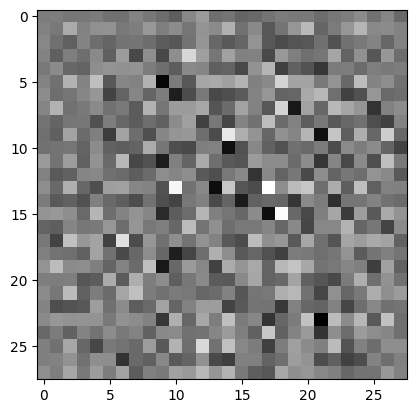

In [ ]:
plt.imshow(imagem_gerada[0, :, :, 0], cmap='gray')

# Construção do discriminador

In [ ]:
def cria_discriminador():
  network = tf.keras.Sequential()

  network.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28,28,1]))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  network.add(layers.LeakyReLU())
  network.add(layers.Dropout(0.3))

  network.add(layers.Flatten())
  network.add(layers.Dense(1))

  network.summary()

  return network

In [ ]:
discriminador = cria_discriminador()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 14, 14, 64)        1664      
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 14, 14, 64)        0         
                                                                 
 dropout (Dropout)           (None, 14, 14, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 7, 7, 128)         204928    
                                                                 
 leaky_re_lu_4 (LeakyReLU)   (None, 7, 7, 128)         0         
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 128)         0         
                                                                 
 flatten (Flatten)           (None, 6272)             

In [ ]:
discriminador.input

<KerasTensor: shape=(None, 28, 28, 1) dtype=float32 (created by layer 'conv2d_input')>

Testando o discriminador

In [ ]:
discriminador(imagem_gerada, training=False)

<tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[0.00366593]], dtype=float32)>

# Cálculo do erro

In [ ]:
cross_entropy = tf.keras.losses.BinaryFocalCrossentropy(from_logits=True)

In [ ]:
def discriminador_loss(expected_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(expected_output), expected_output)
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
  total_loss = real_loss + fake_loss
  return total_loss

In [ ]:
def gerador_loss(fake_output):
  return cross_entropy(tf.ones_like(fake_output), fake_output)

In [ ]:
gerador_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)
discriminador_optimizer = tf.keras.optimizers.Adam(learning_rate = 0.00001)

# Treinamento da GAN

In [ ]:
epocas = 100
dimensao_ruido = 100
numero_imagens = 16

In [ ]:
@tf.function
def treinamento(imagens):
  ruido = tf.random.normal([batch_size, dimensao_ruido])
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    imagens_geradas = gerador(ruido, training=True)

    expected_output = discriminador(imagens, training=True)
    fake_output = discriminador(imagens_geradas, training=True)

    gen_loss = gerador_loss(fake_output)
    disc_loss = discriminador_loss(expected_output, fake_output)

  gradientes_gerador = gen_tape.gradient(gen_loss, gerador.trainable_variables)
  gradientes_discriminador = disc_tape.gradient(disc_loss, discriminador.trainable_variables)

  gerador_optimizer.apply_gradients(zip(gradientes_gerador, gerador.trainable_variables))
  discriminador_optimizer.apply_gradients(zip(gradientes_discriminador, discriminador.trainable_variables))

In [ ]:
imagens_teste = tf.random.normal([numero_imagens, dimensao_ruido])
imagens_teste.shape

TensorShape([16, 100])

In [ ]:
def treina_gan(dataset, epocas, imagens_teste):
  for epoca in range(epocas):
    for imagem_batch in dataset:
      treinamento(imagem_batch)
    print(f'Época: {epoca + 1}')
    imagens_geradas = gerador(imagens_teste, training=False)
    fig = plt.figure(figsize=(10,10))
    for i in range(imagens_geradas.shape[0]):
      plt.subplot(4,4, i + 1)
      plt.imshow(imagens_geradas[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')
    plt.show()

Época: 1


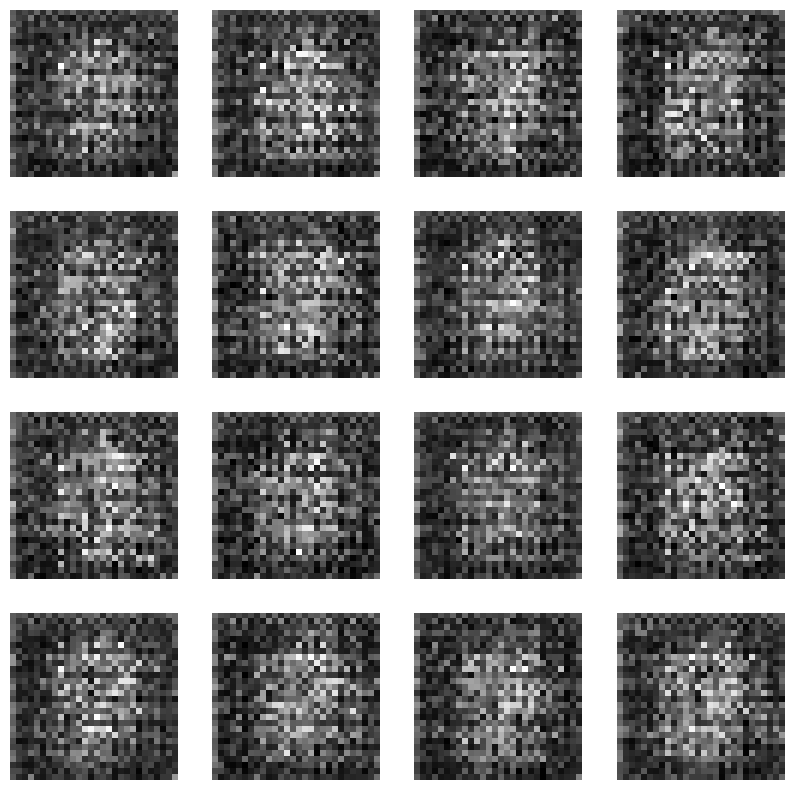

Época: 2


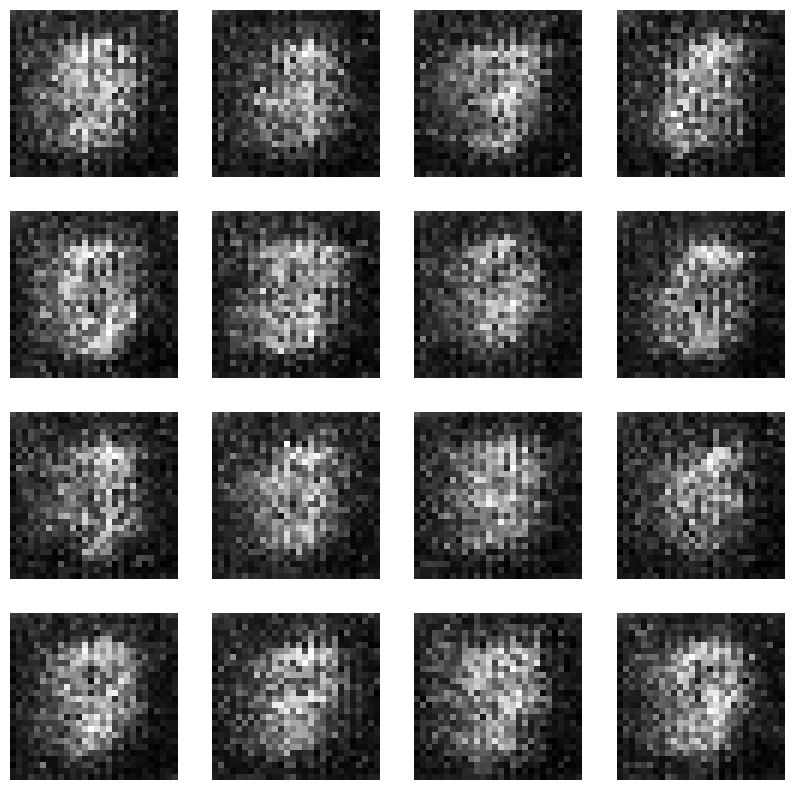

Época: 3


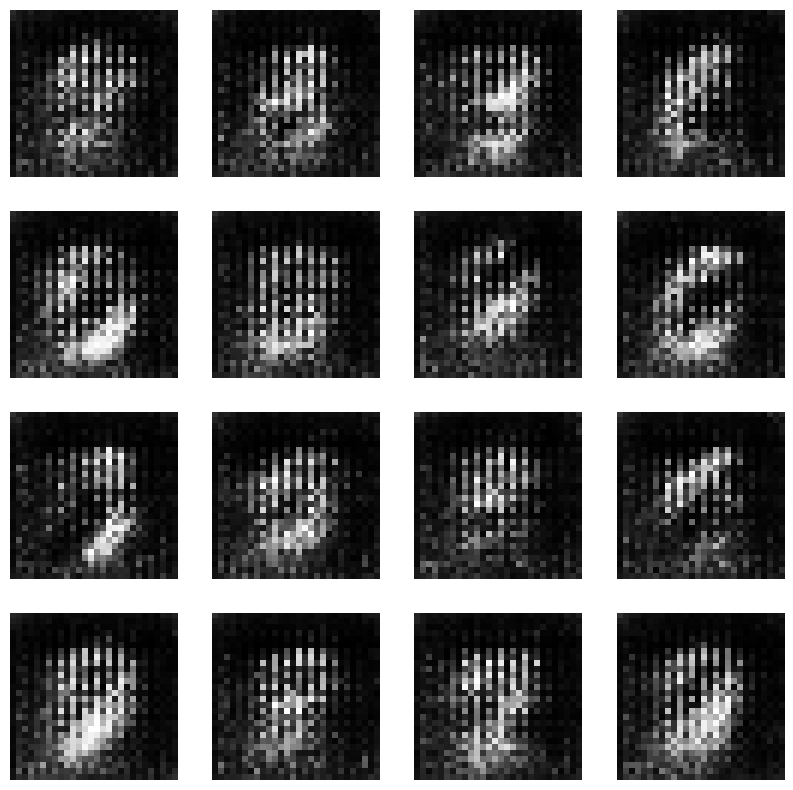

Época: 4


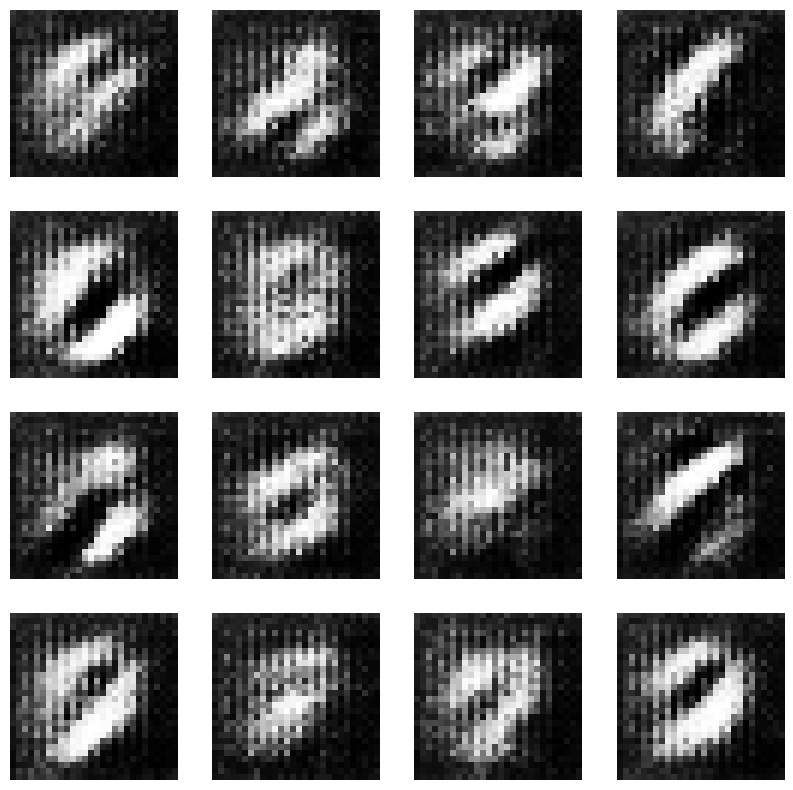

Época: 5


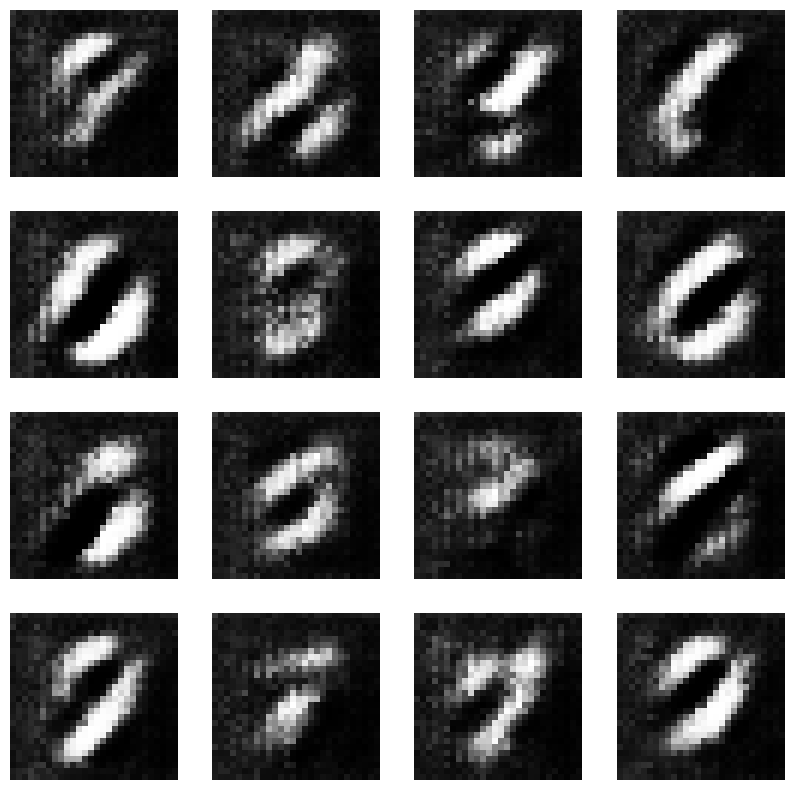

Época: 6


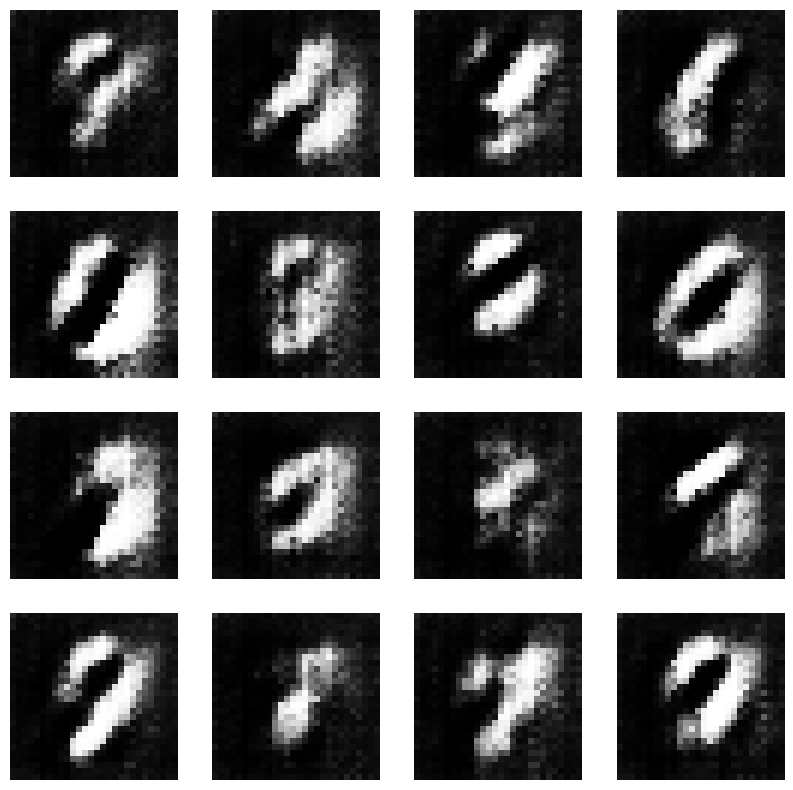

Época: 7


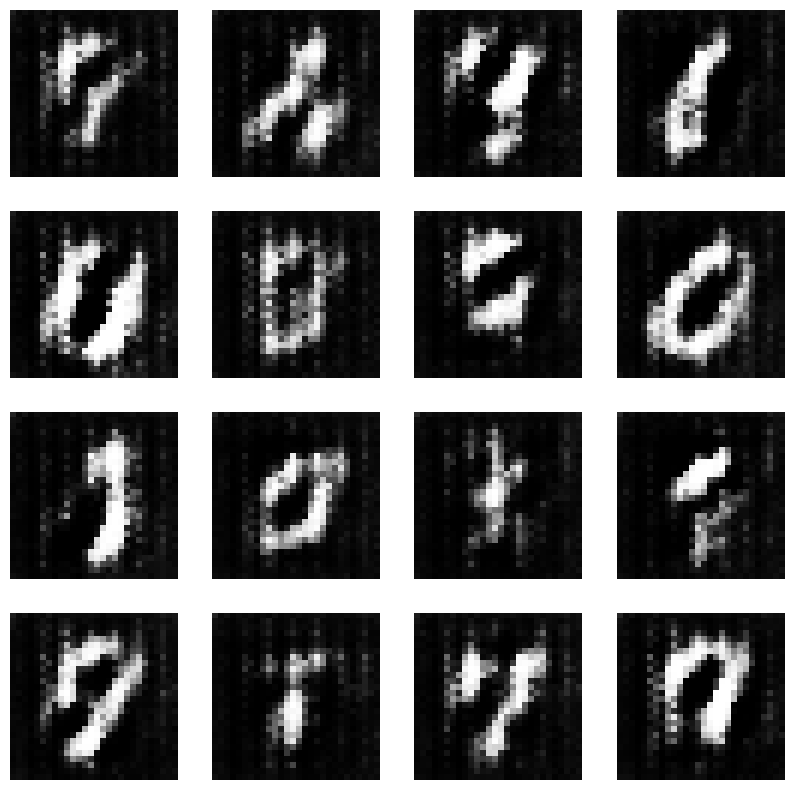

Época: 8


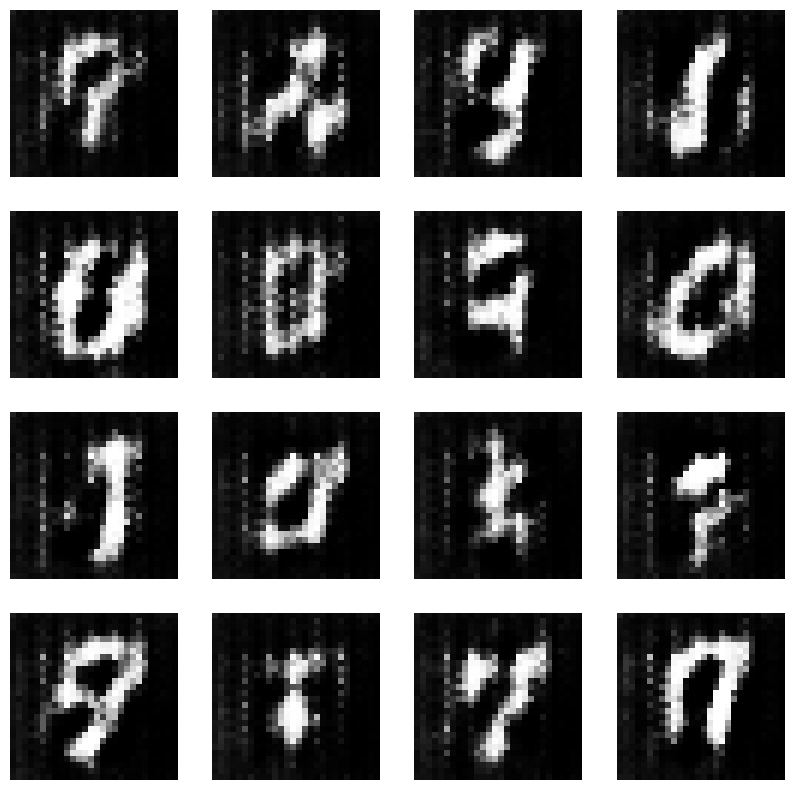

Época: 9


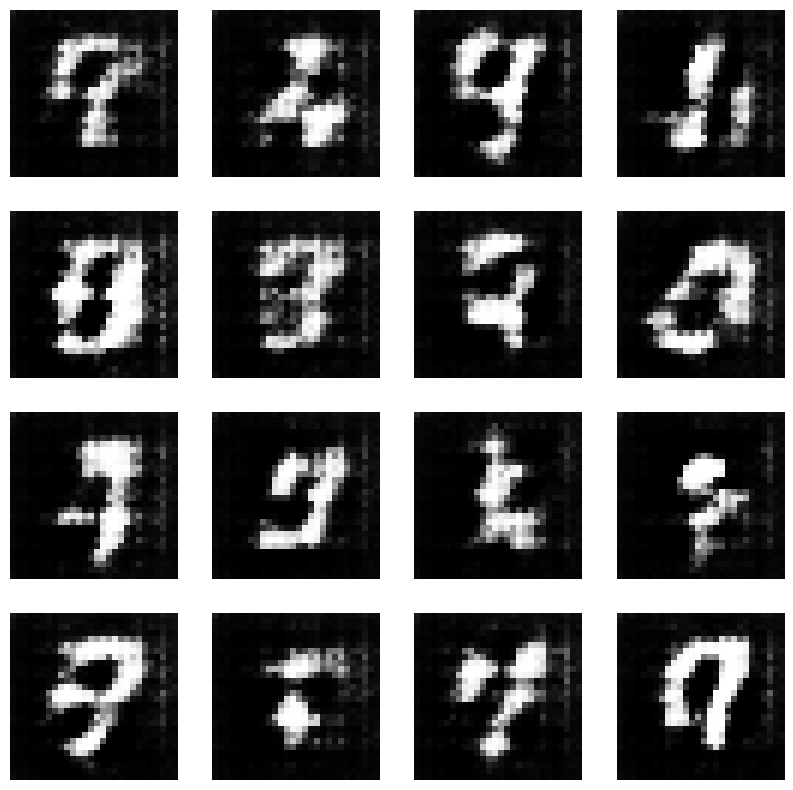

Época: 10


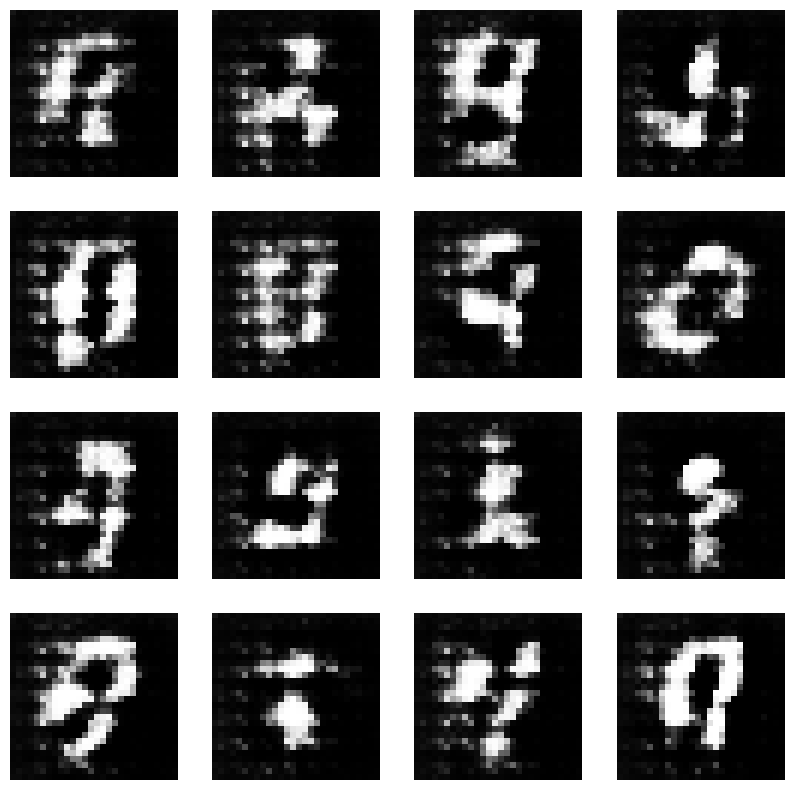

Época: 11


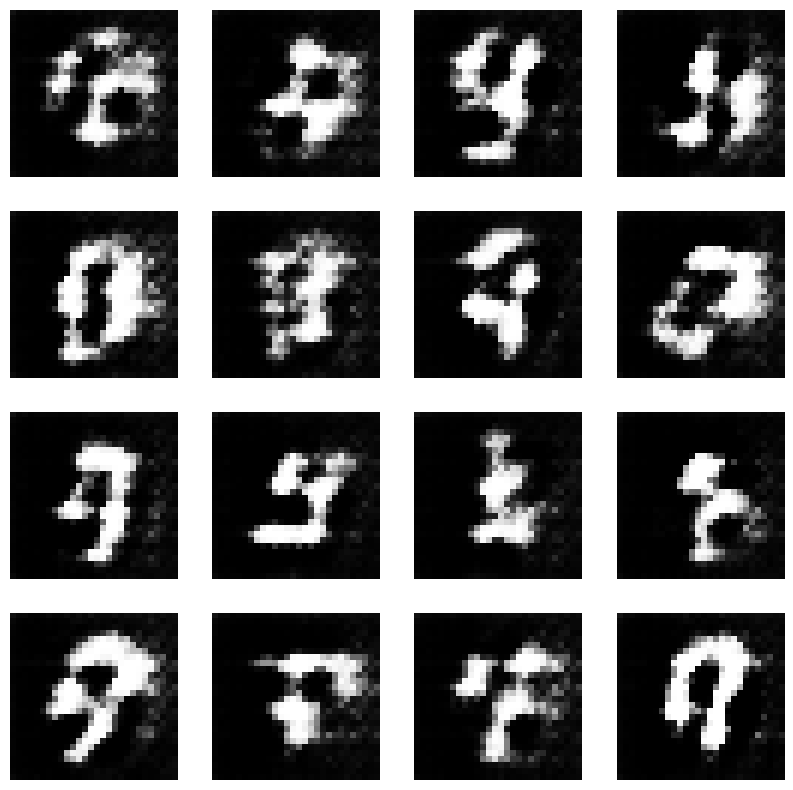

Época: 12


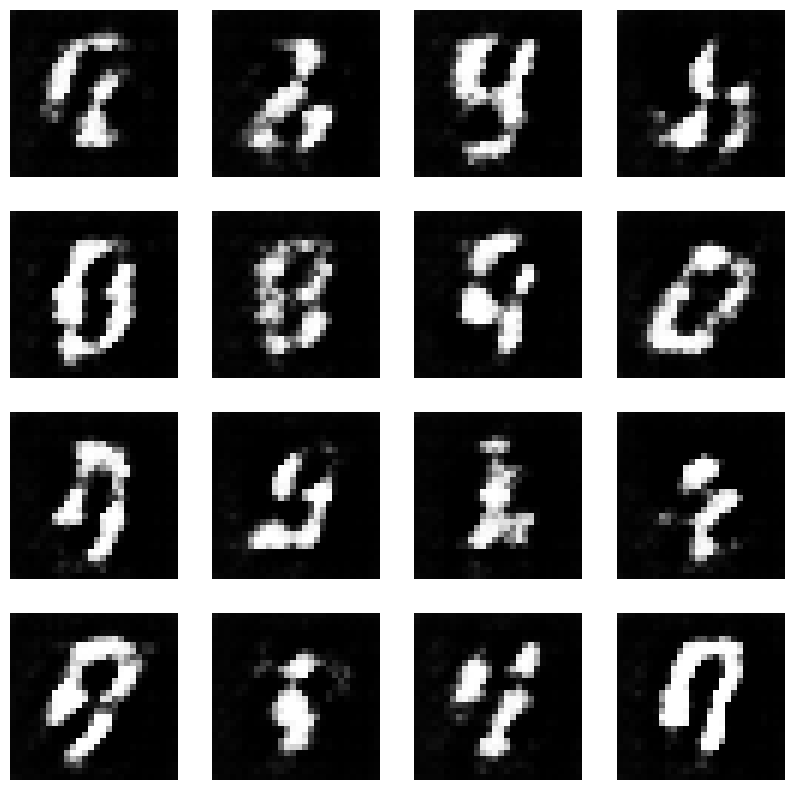

Época: 13


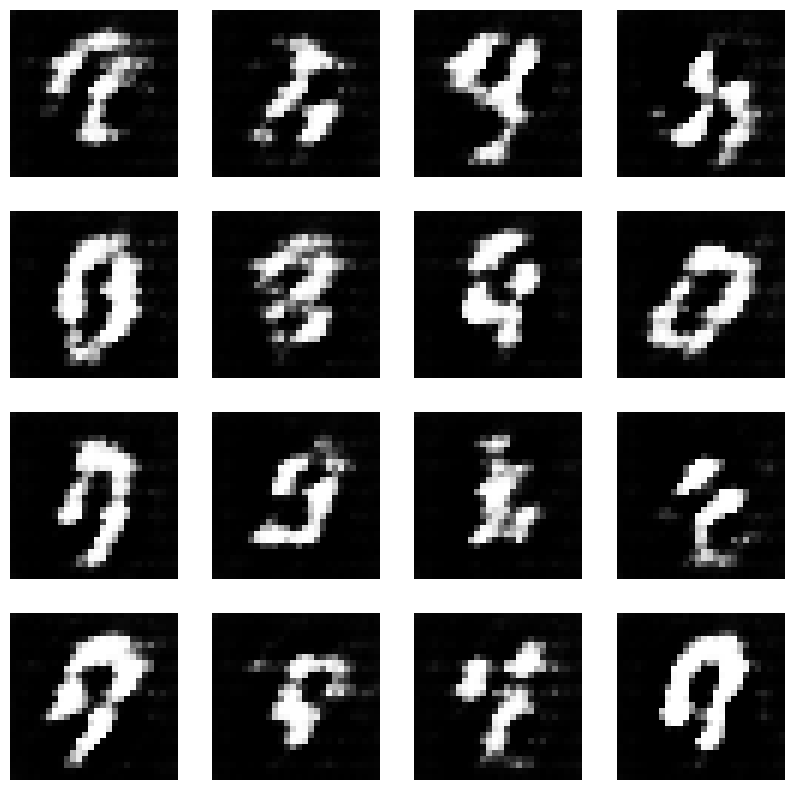

Época: 14


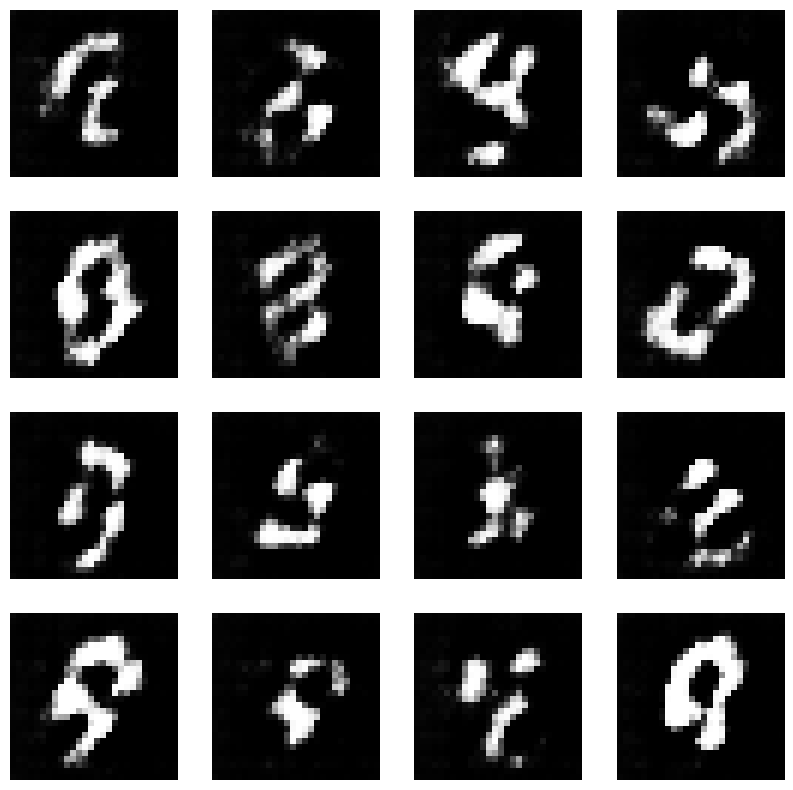

Época: 15


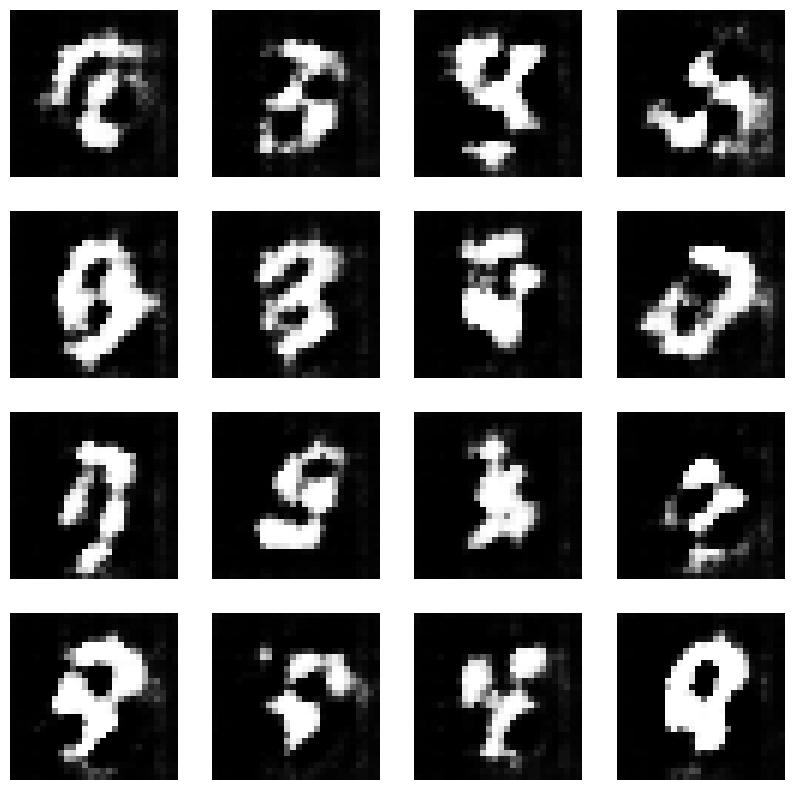

Época: 16


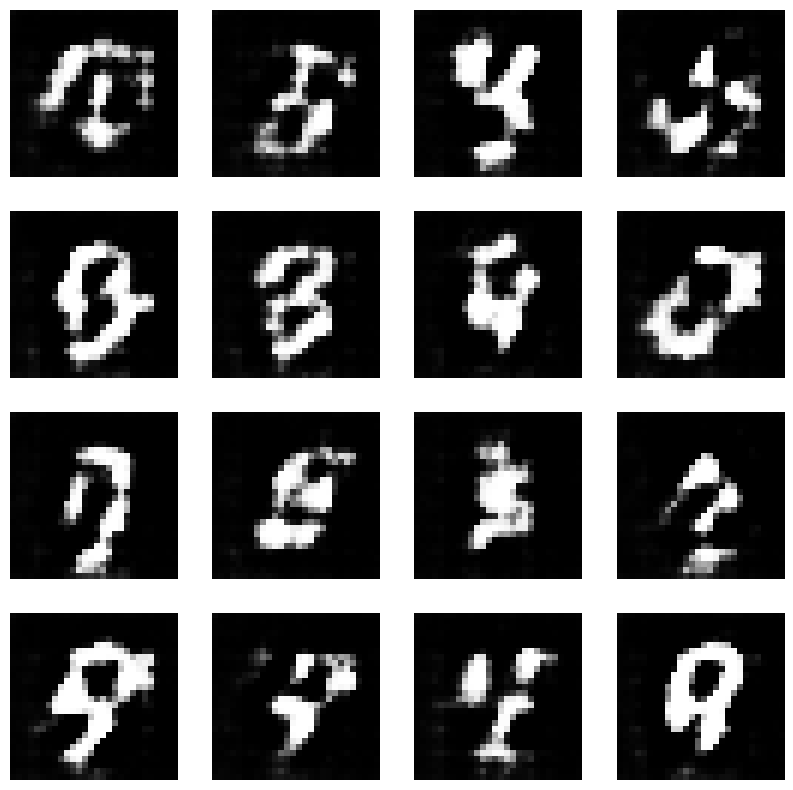

Época: 17


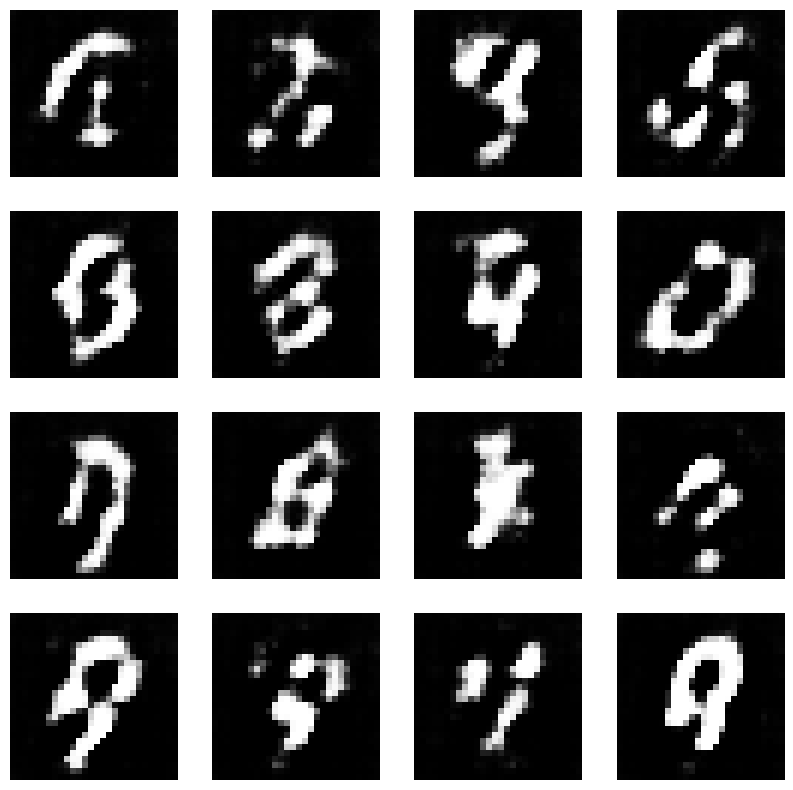

Época: 18


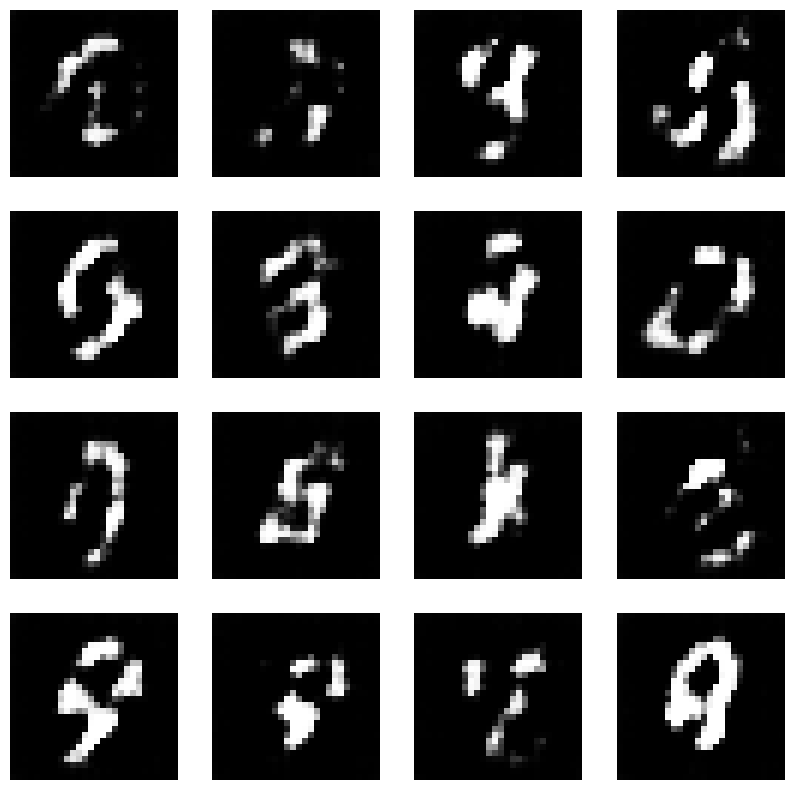

Época: 19


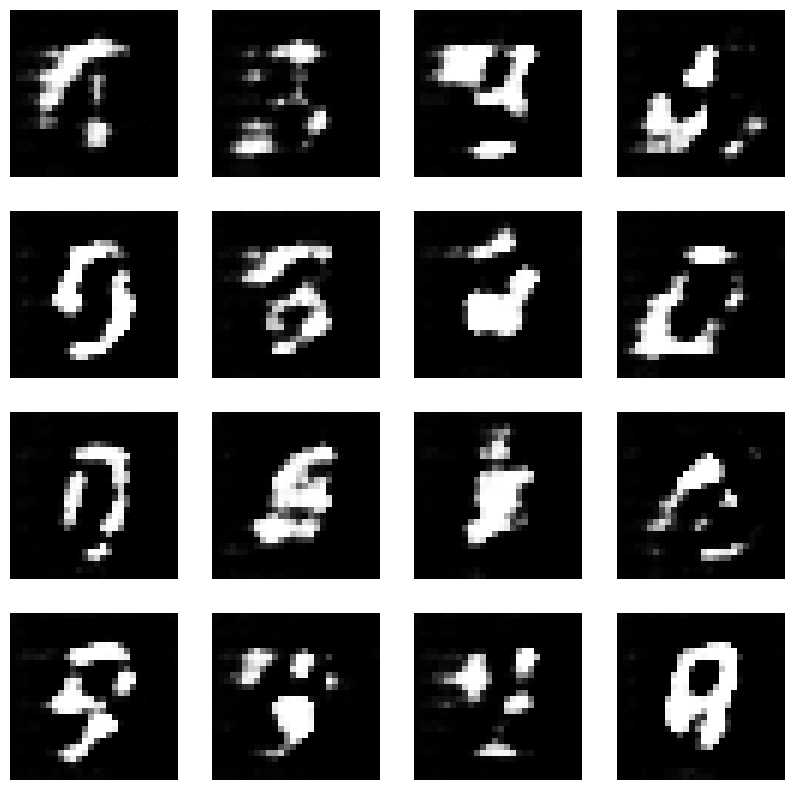

Época: 20


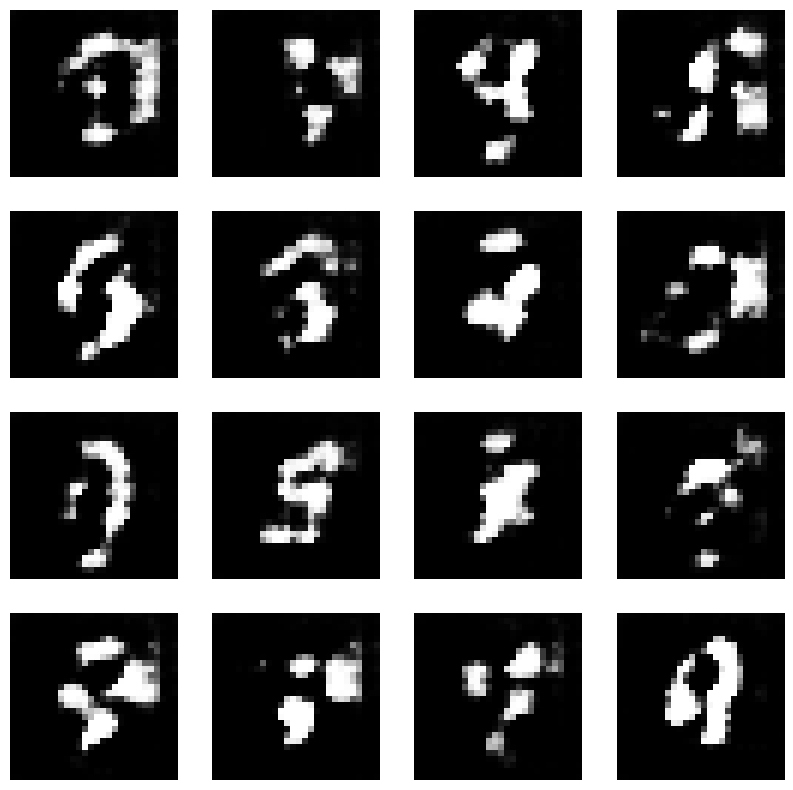

Época: 21


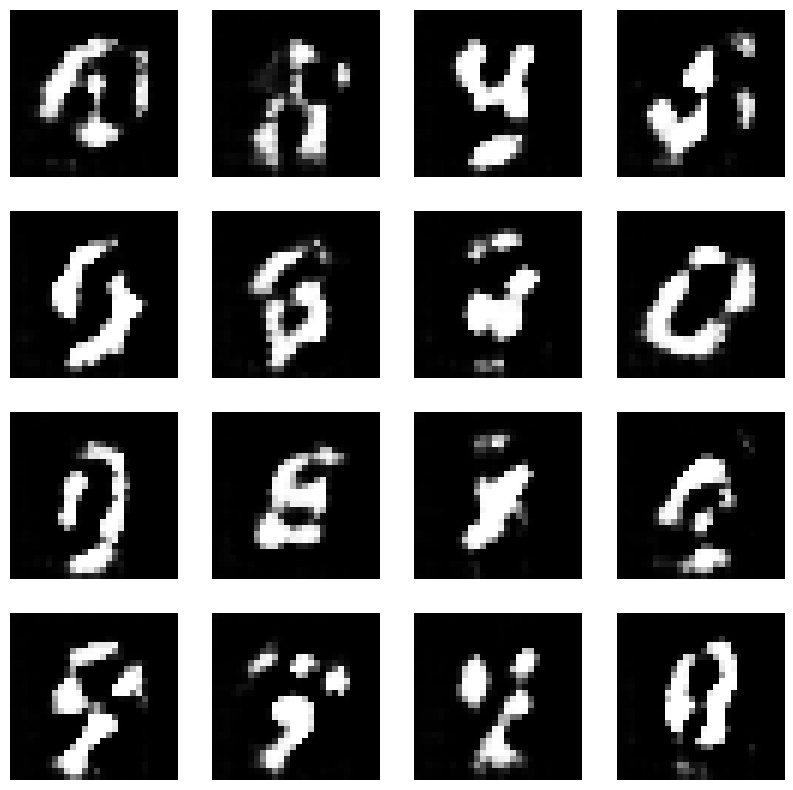

Época: 22


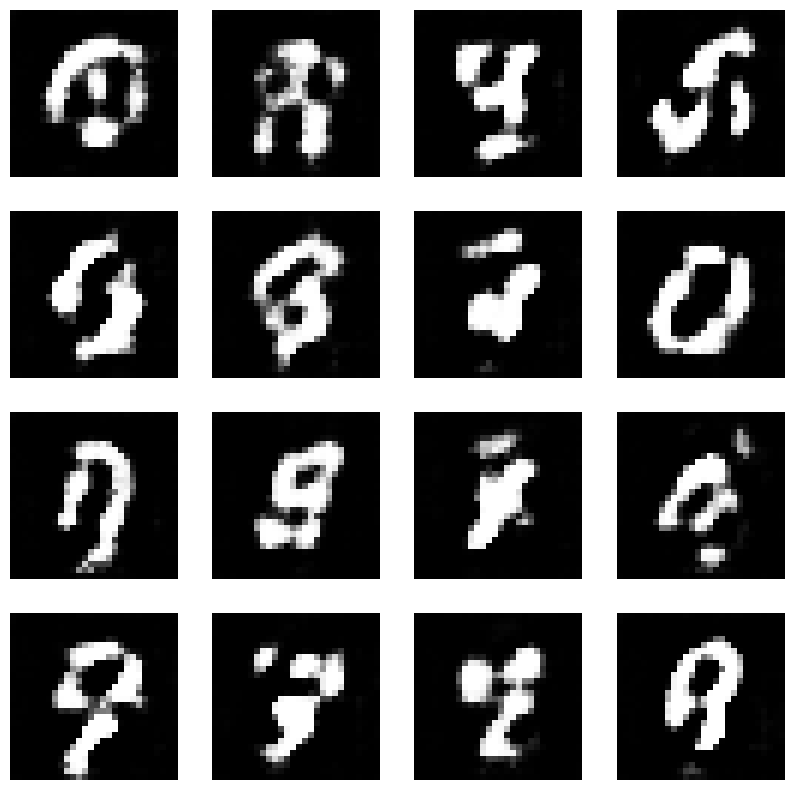

Época: 23


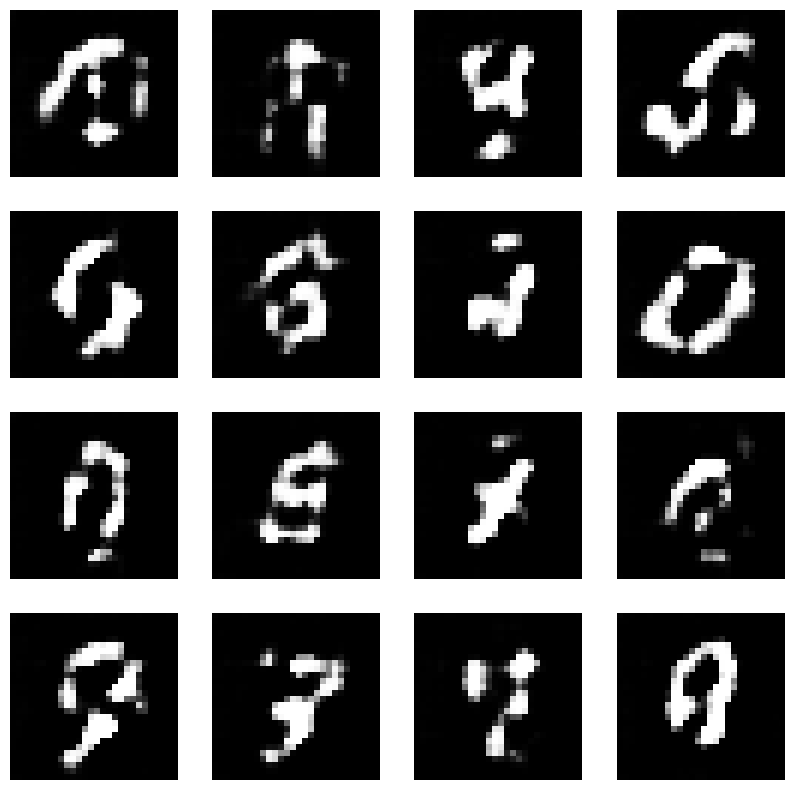

Época: 24


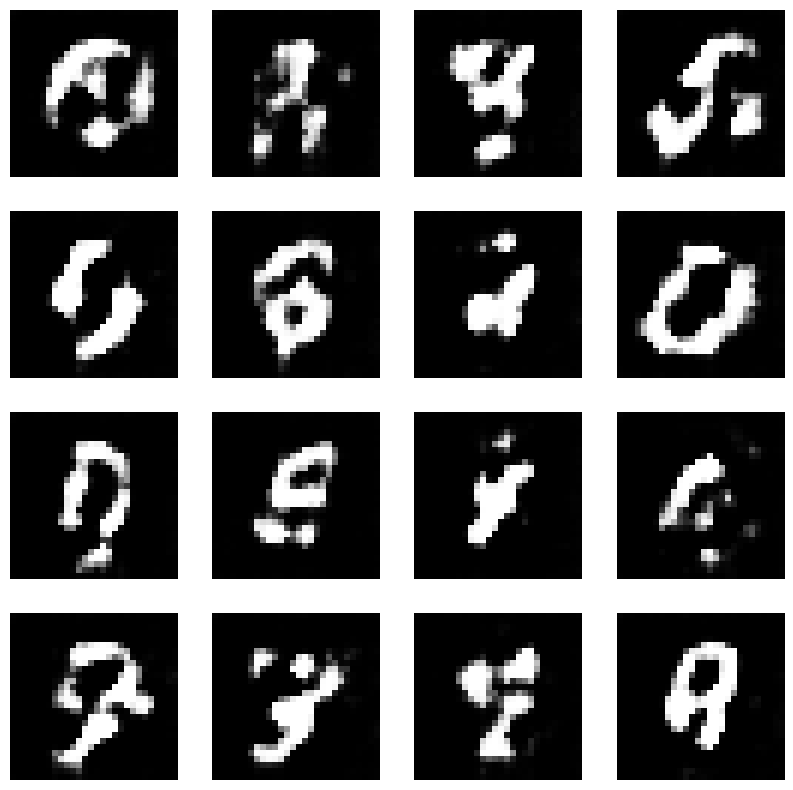

Época: 25


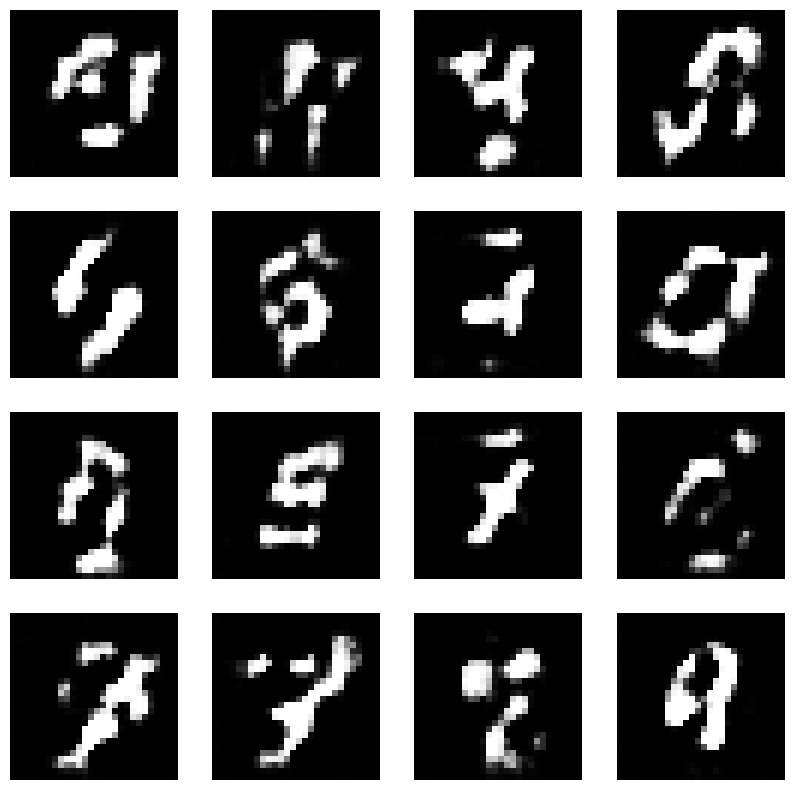

Época: 26


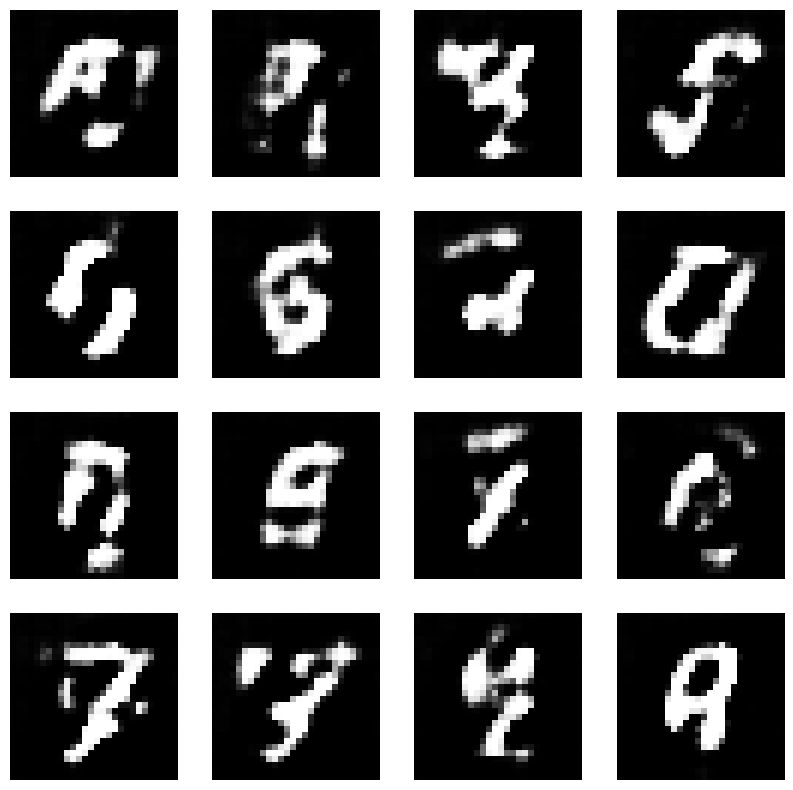

Época: 27


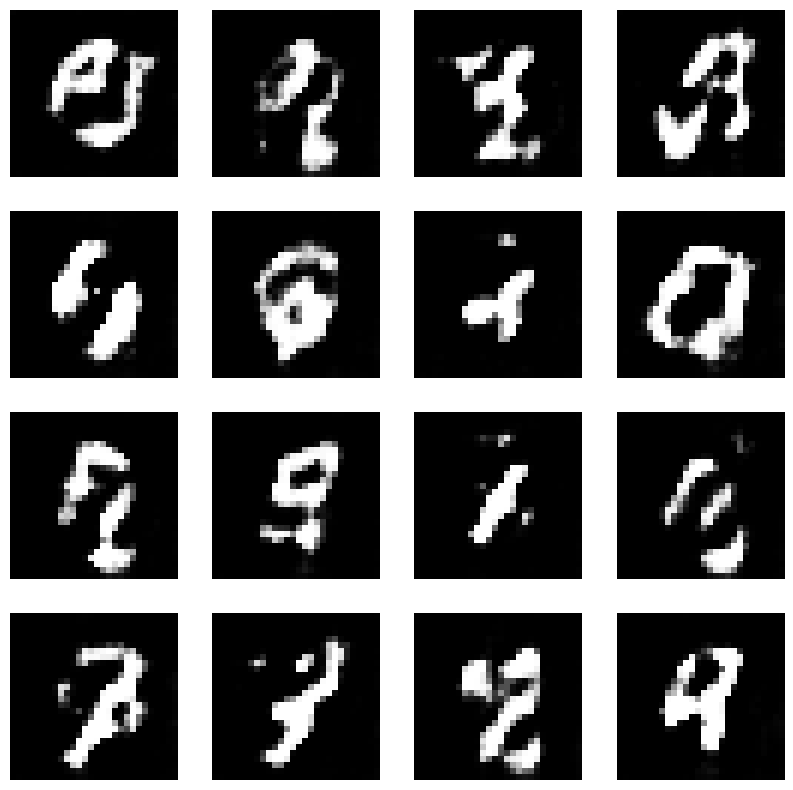

Época: 28


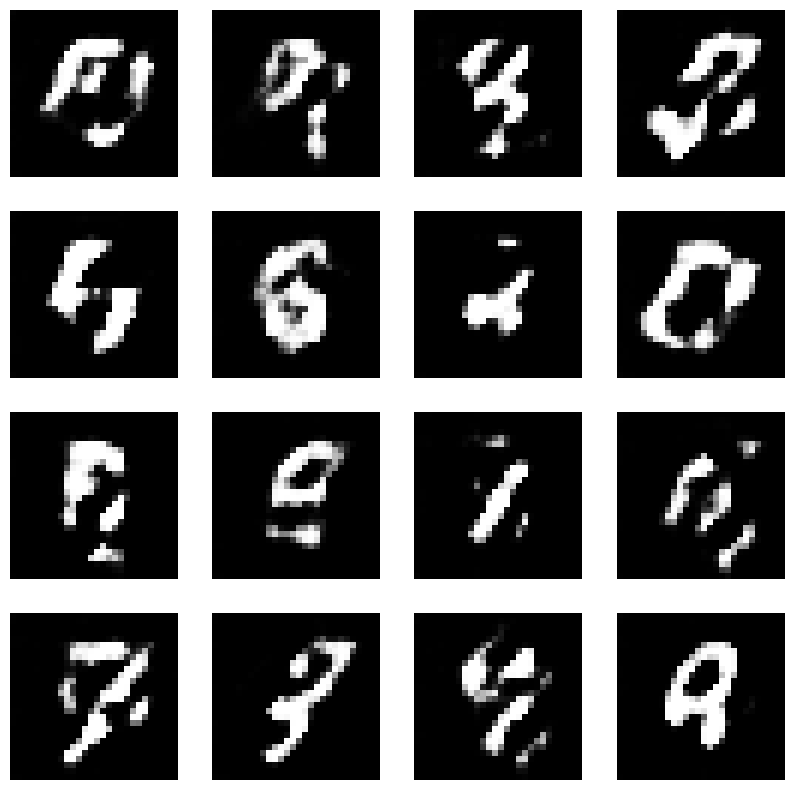

Época: 29


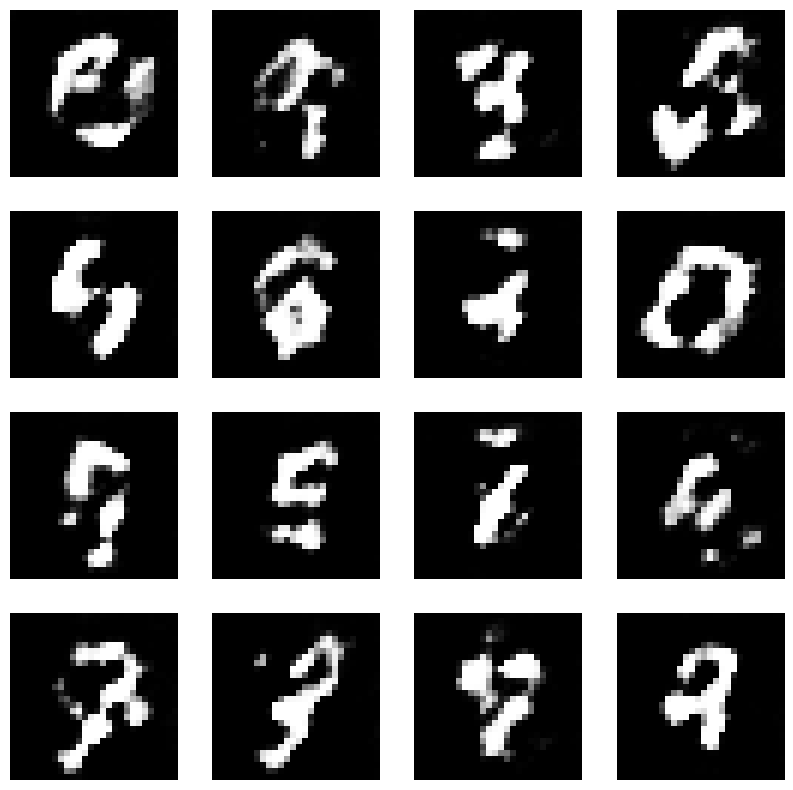

Época: 30


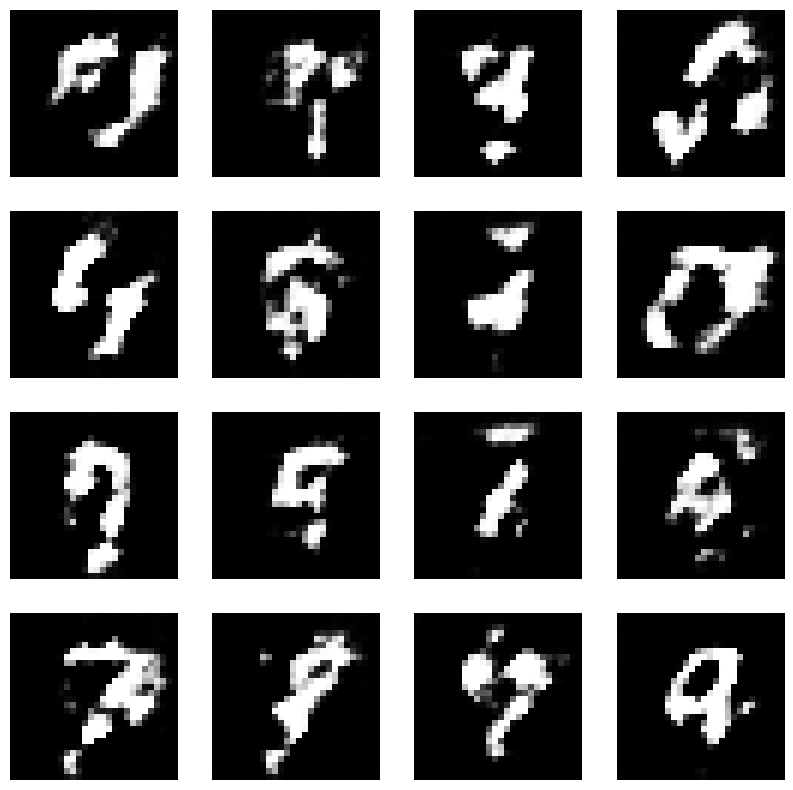

Época: 31


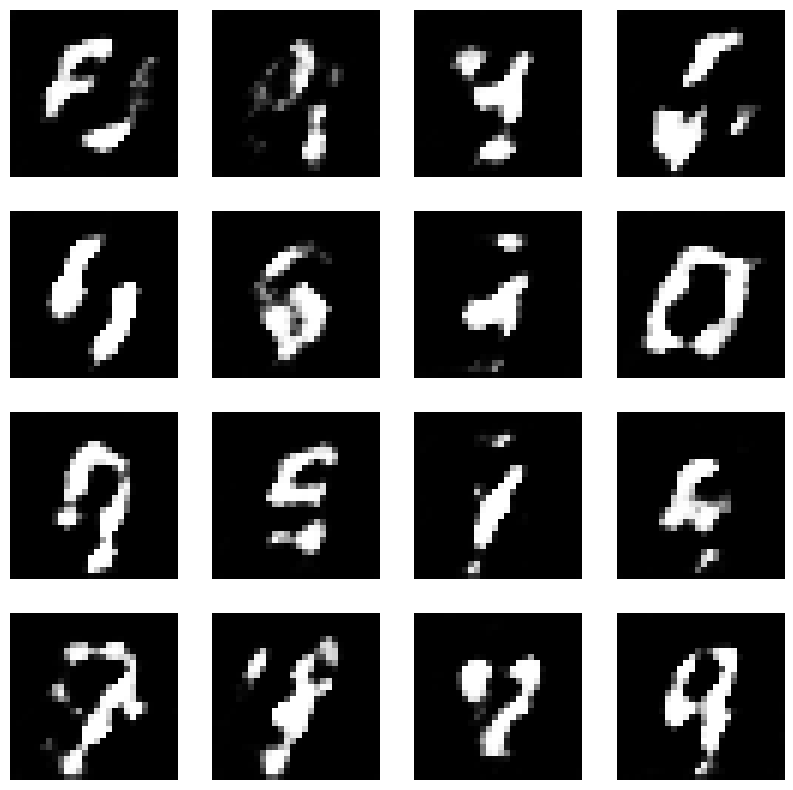

Época: 32


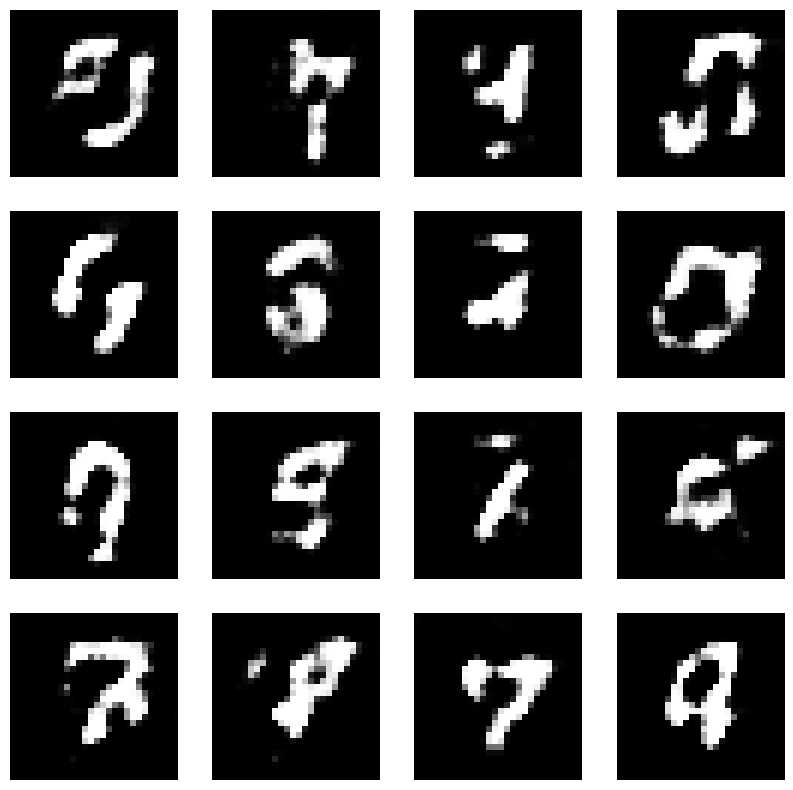

Época: 33


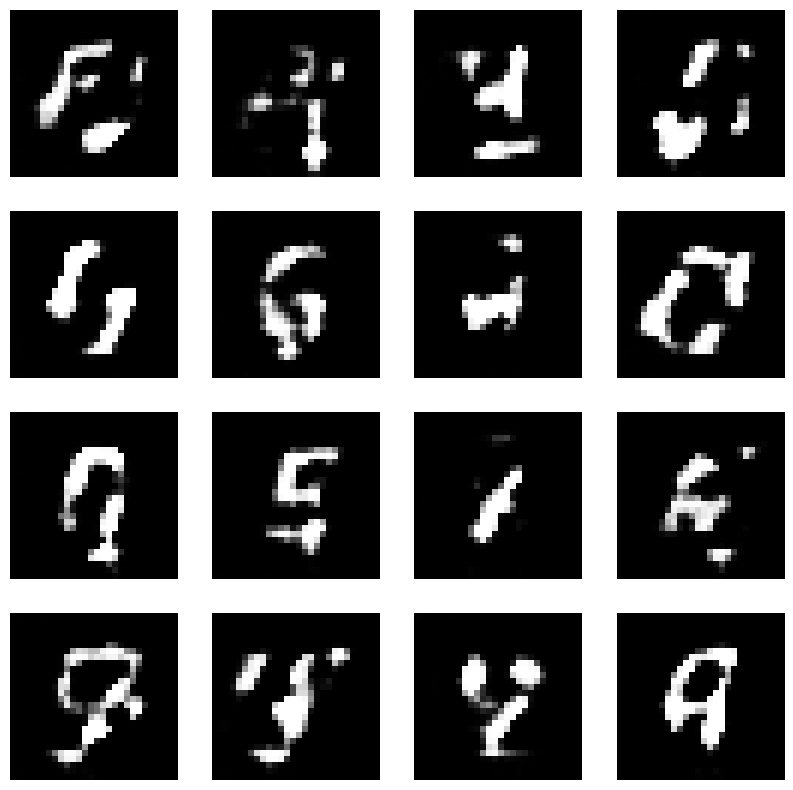

Época: 34


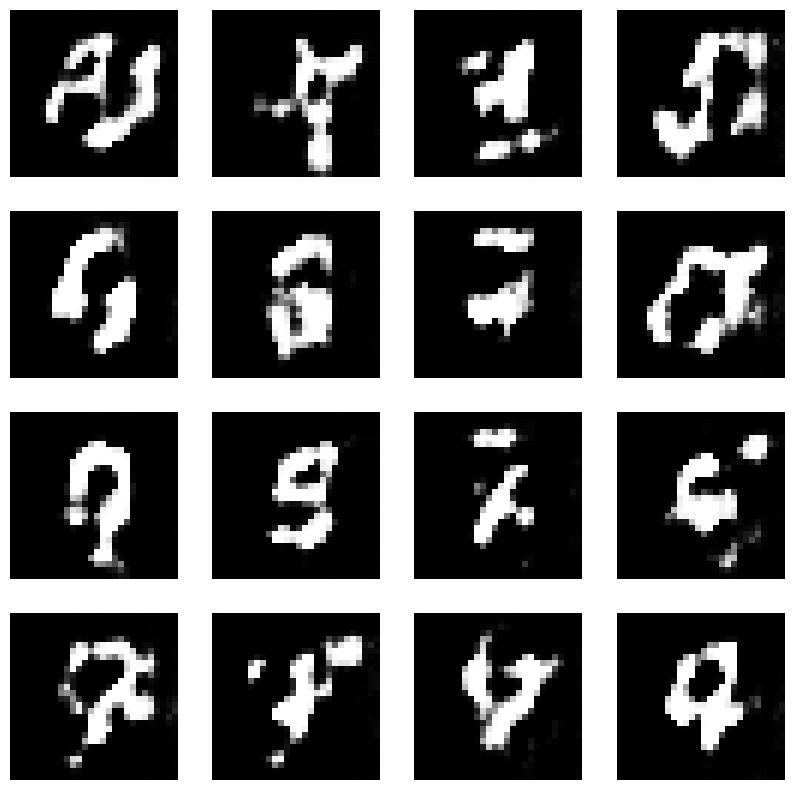

Época: 35


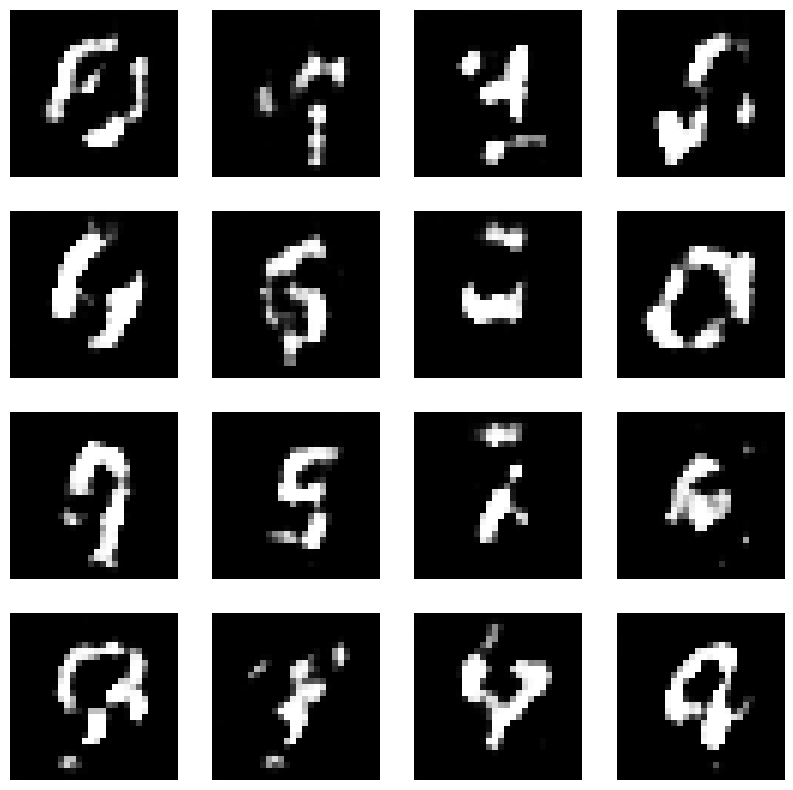

Época: 36


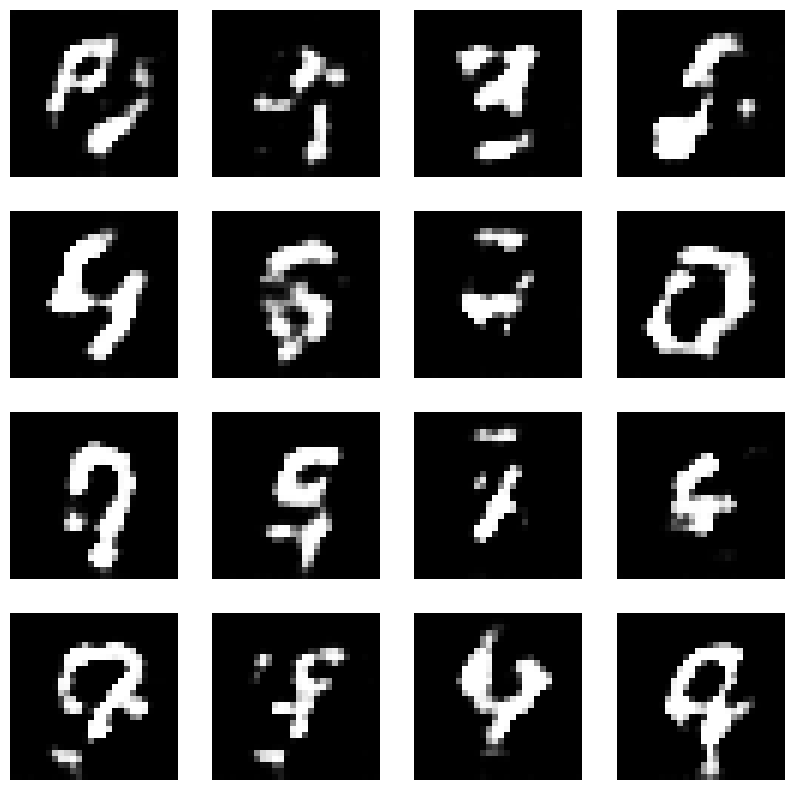

Época: 37


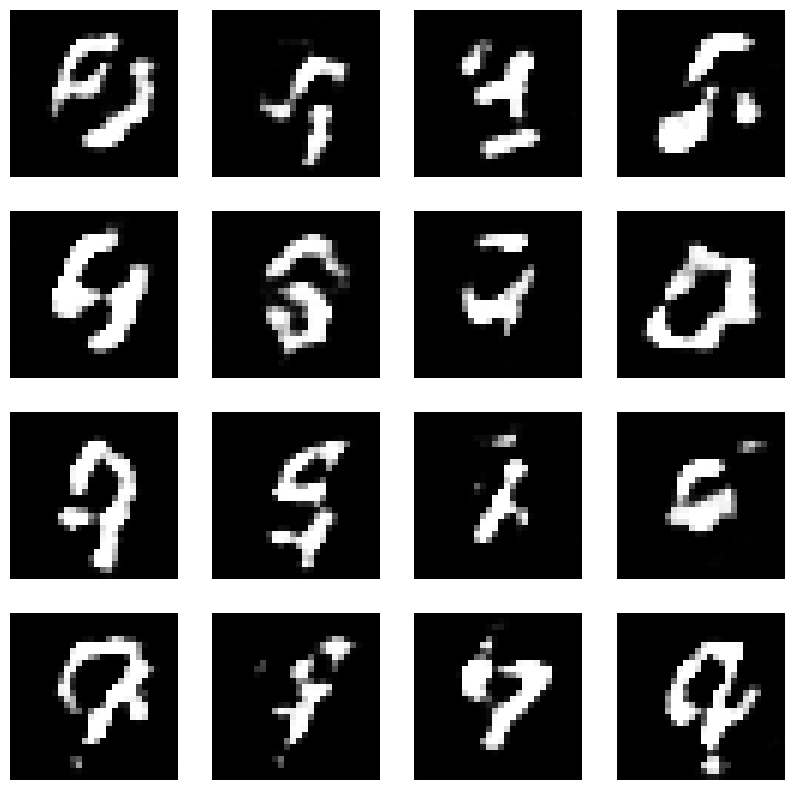

Época: 38


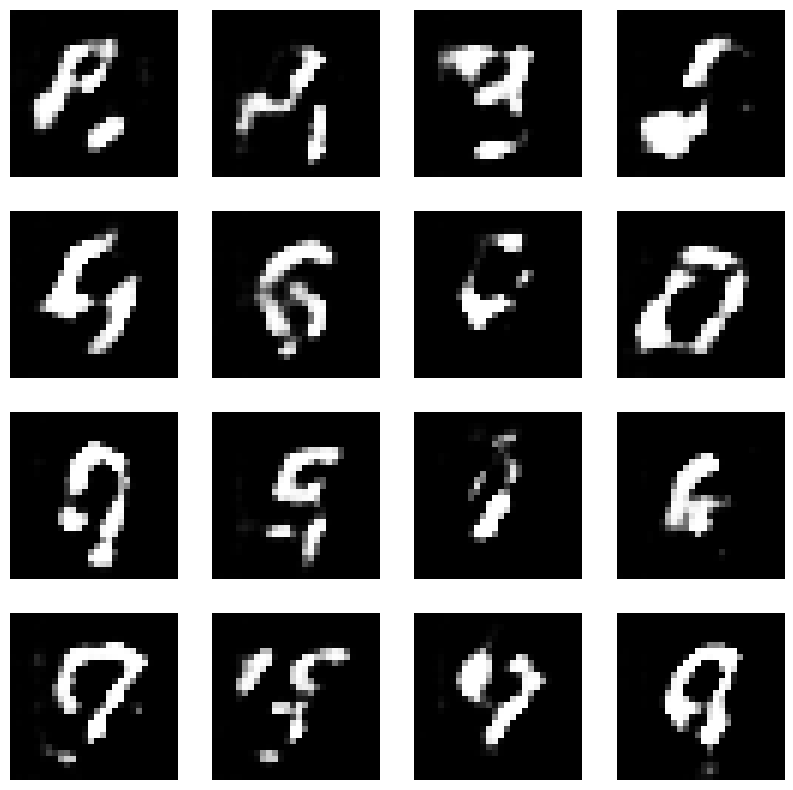

Época: 39


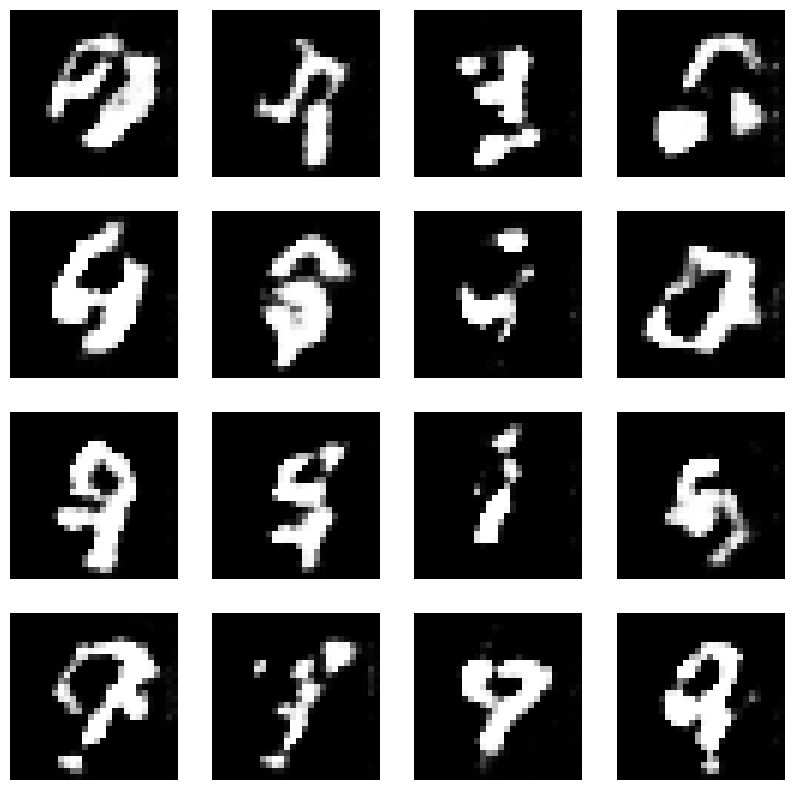

Época: 40


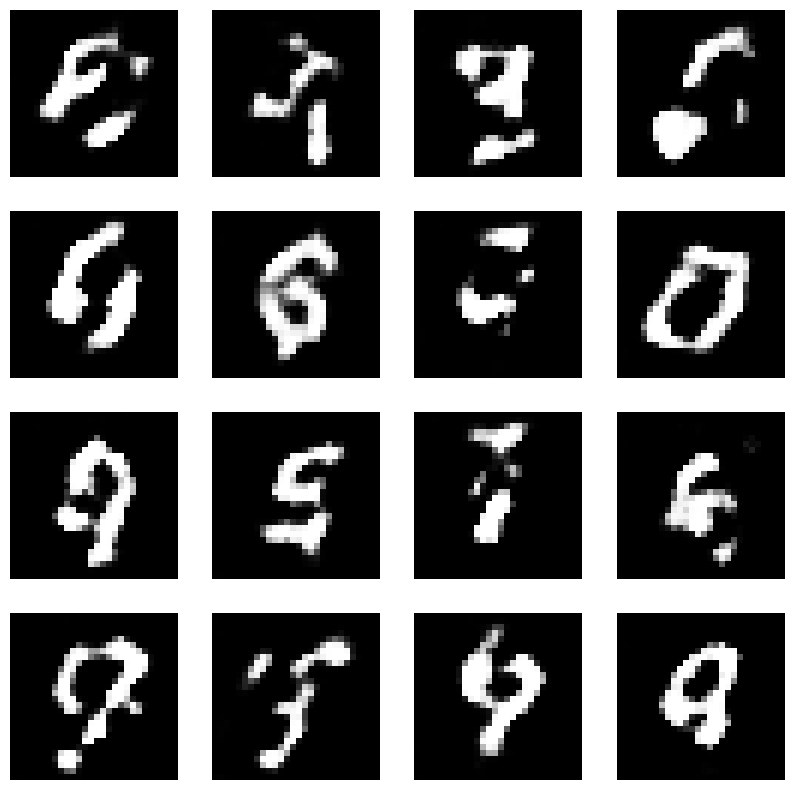

Época: 41


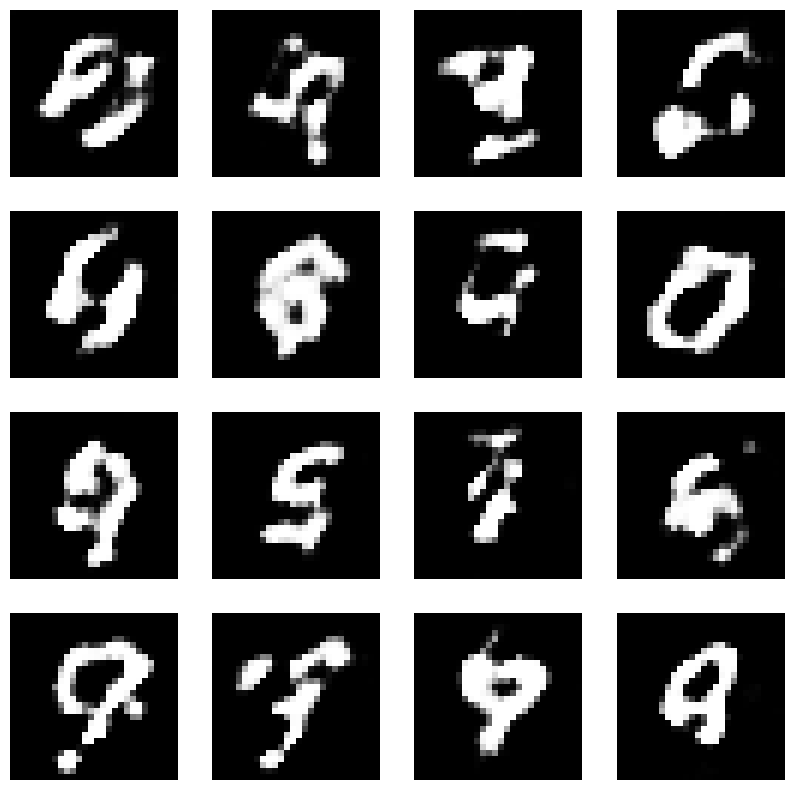

Época: 42


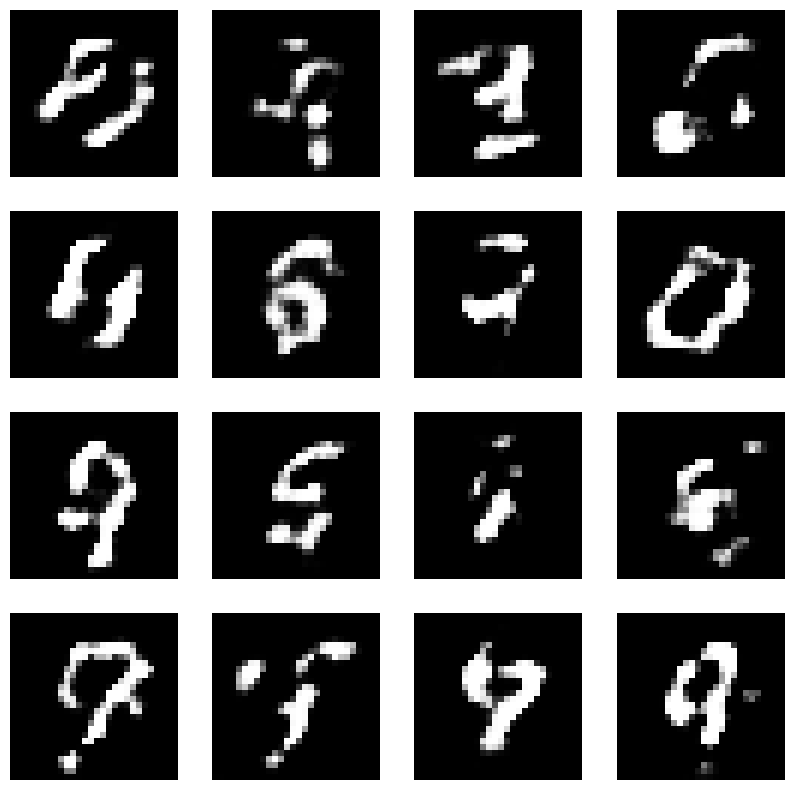

Época: 43


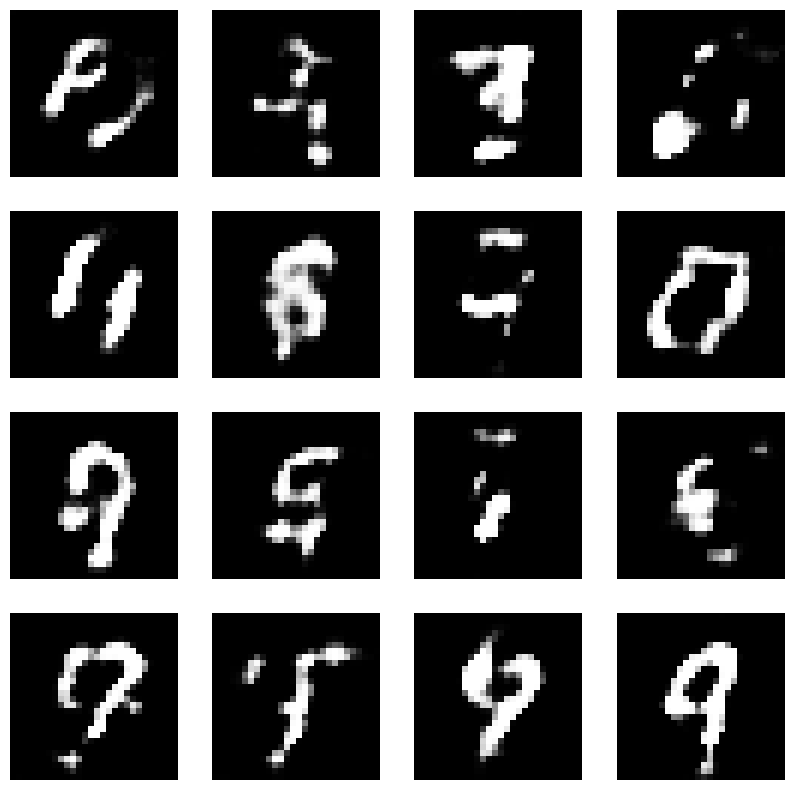

Época: 44


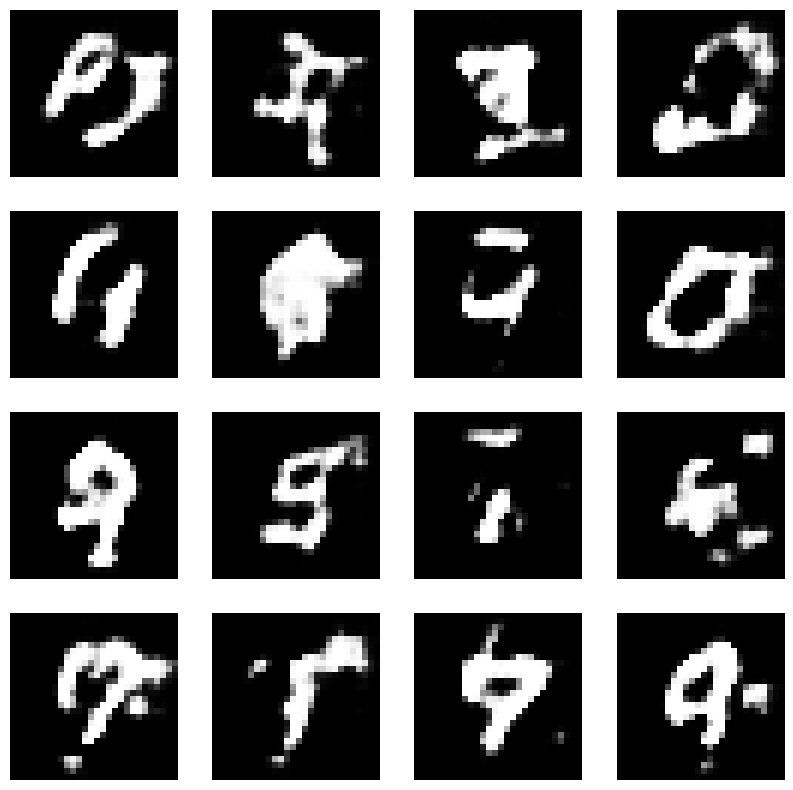

Época: 45


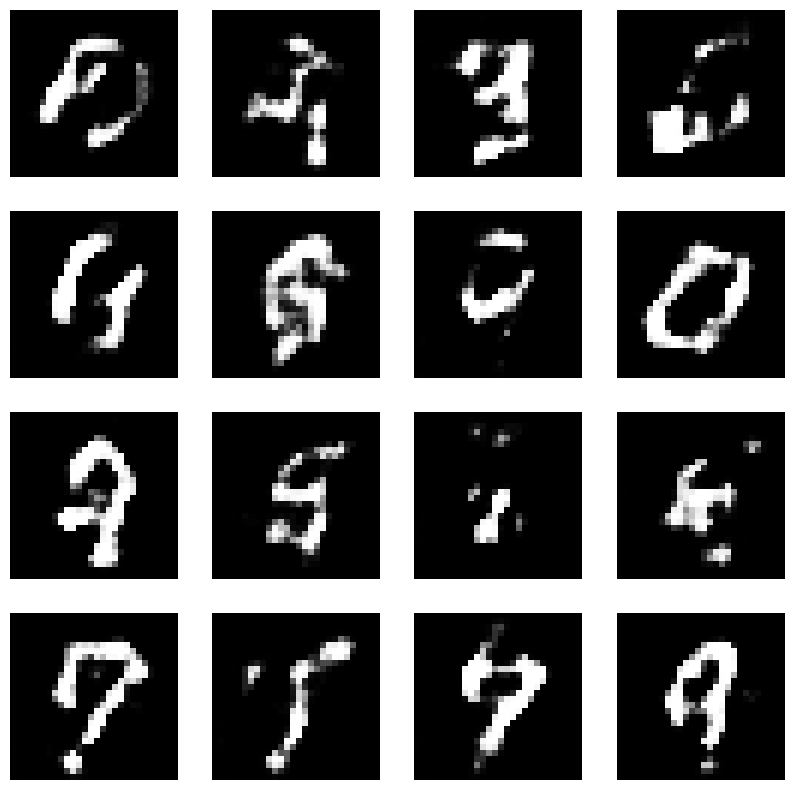

Época: 46


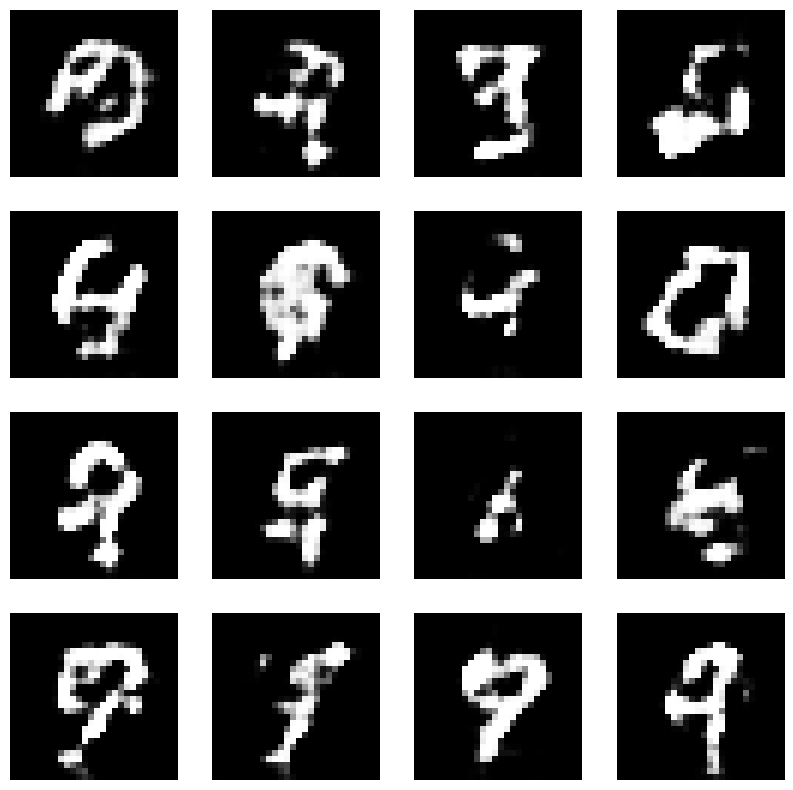

Época: 47


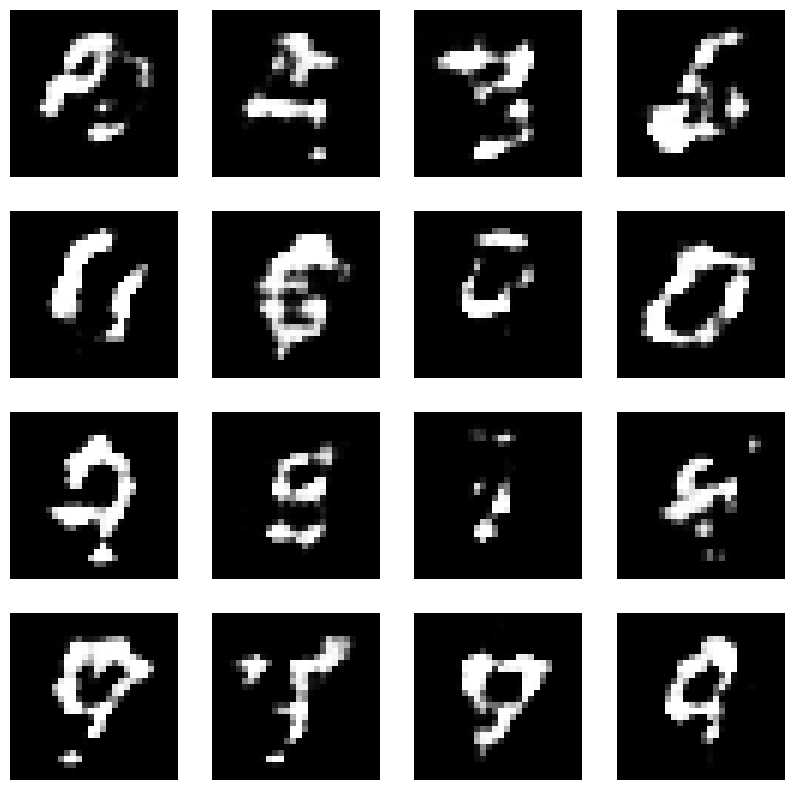

Época: 48


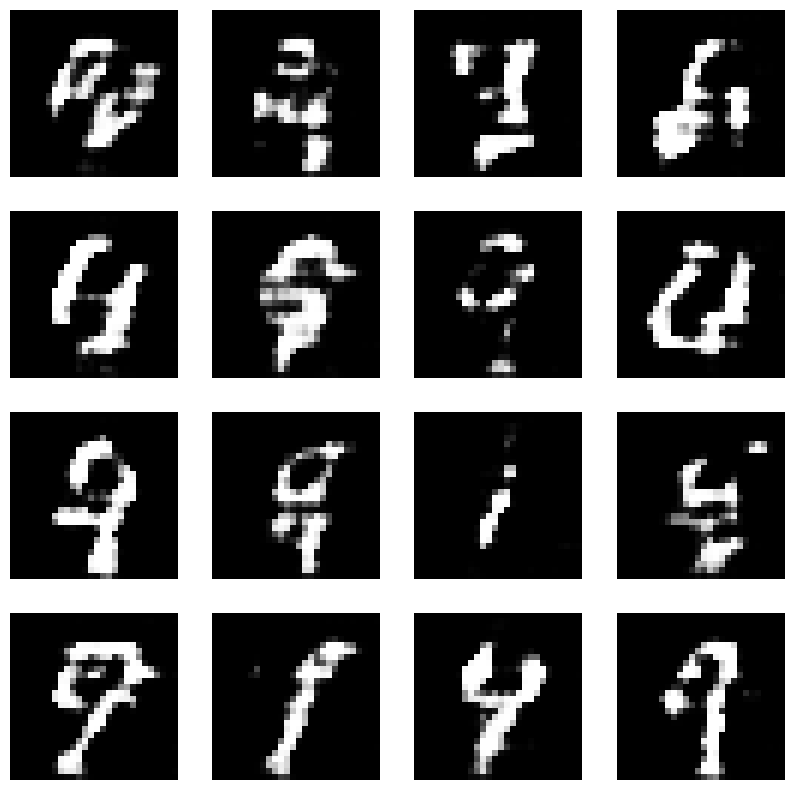

Época: 49


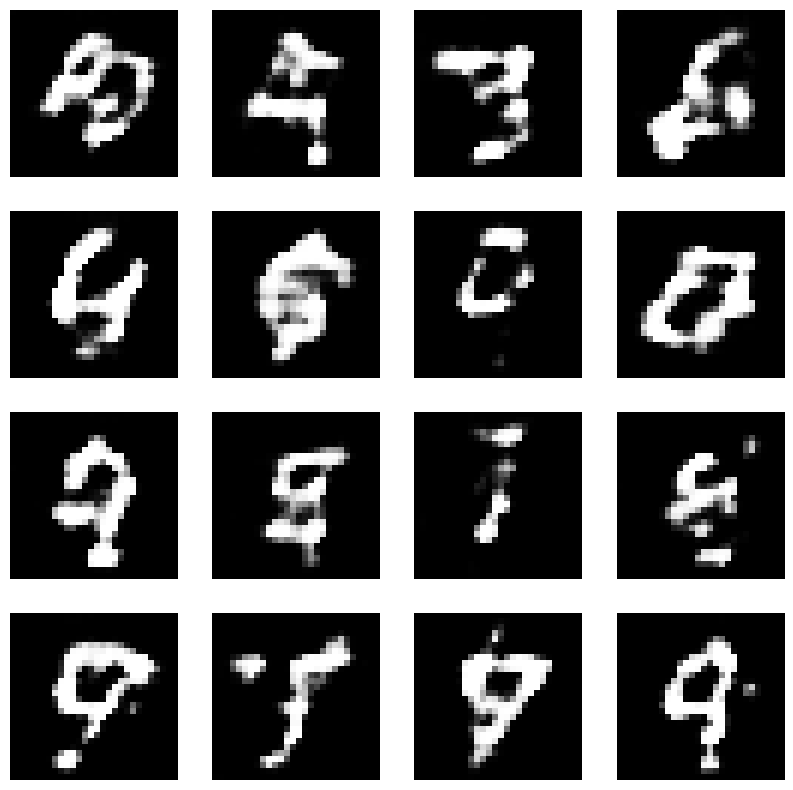

Época: 50


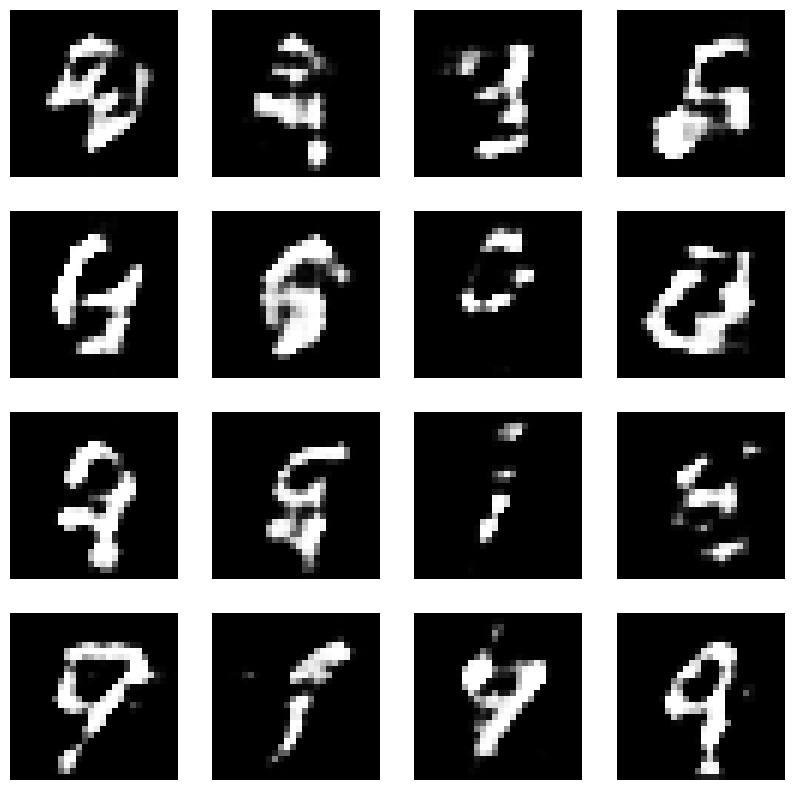

Época: 51


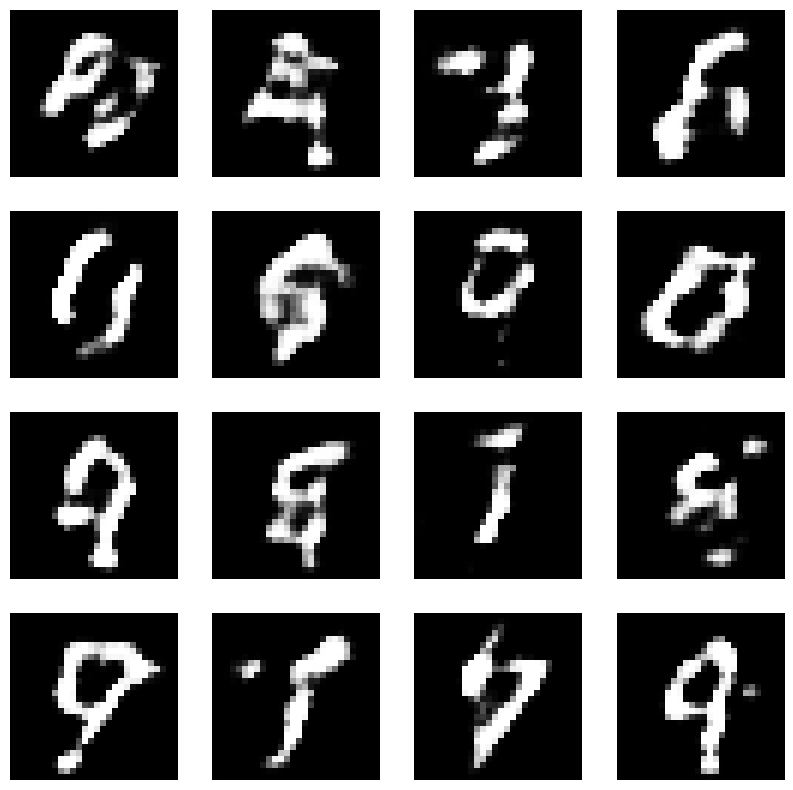

Época: 52


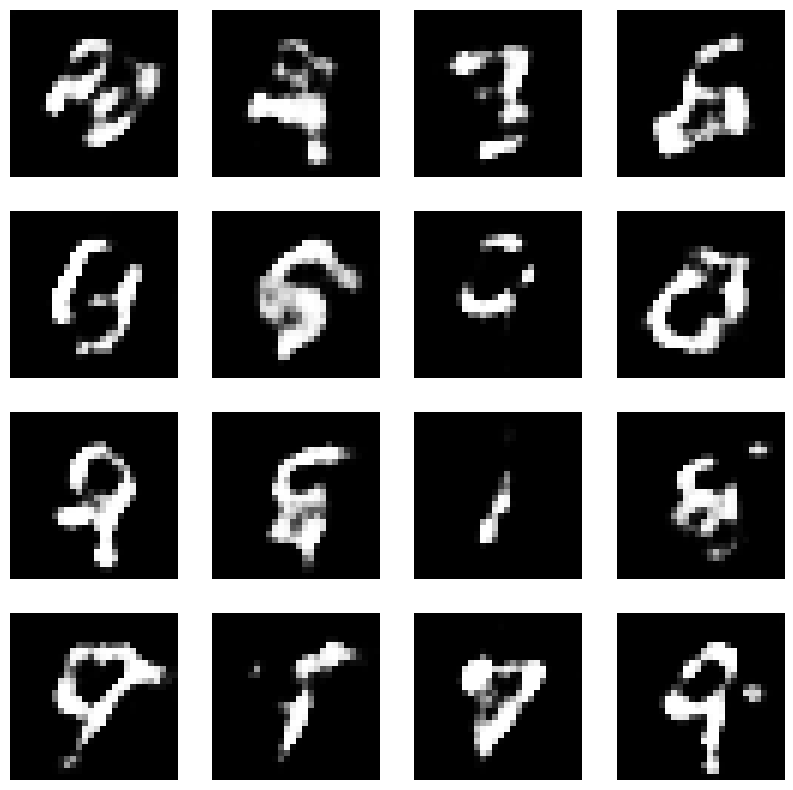

Época: 53


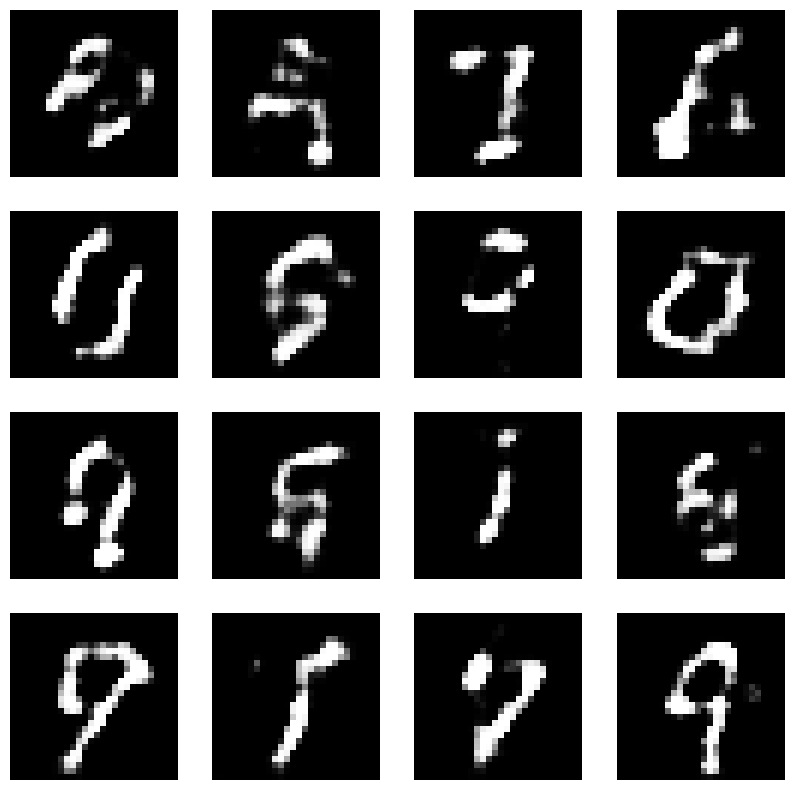

Época: 54


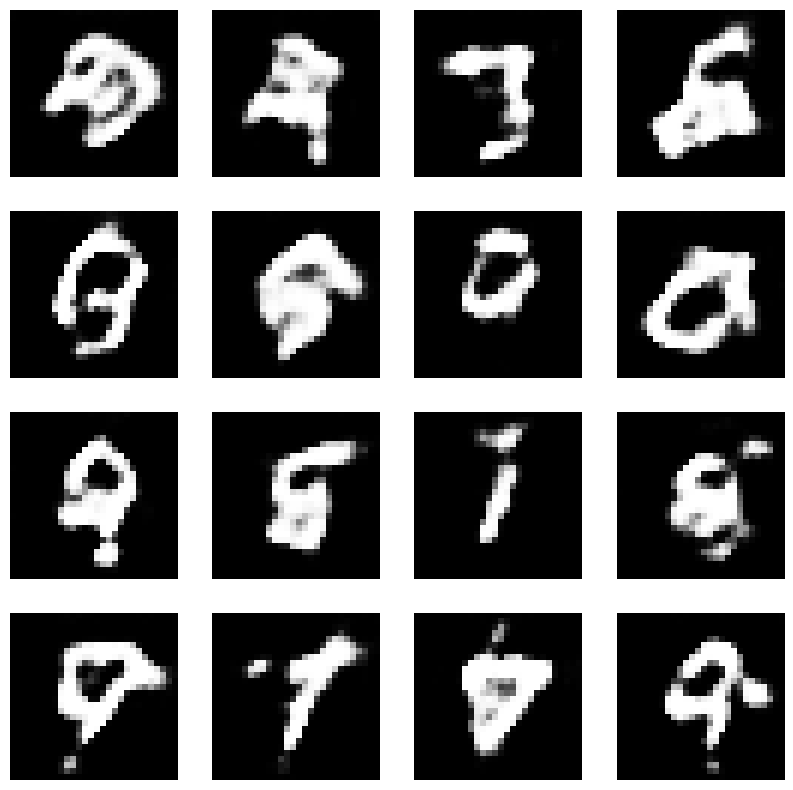

Época: 55


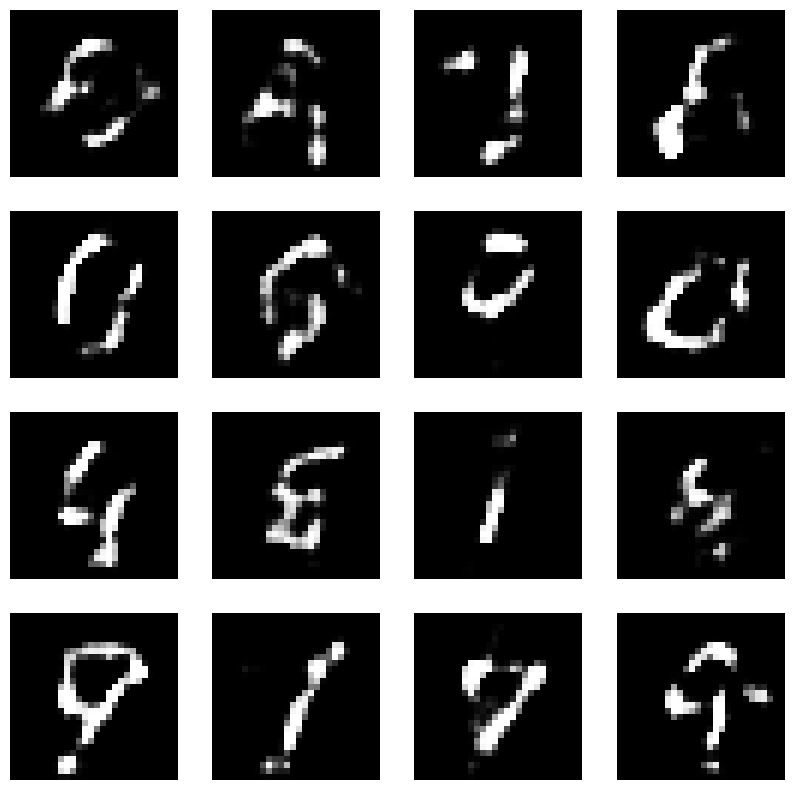

Época: 56


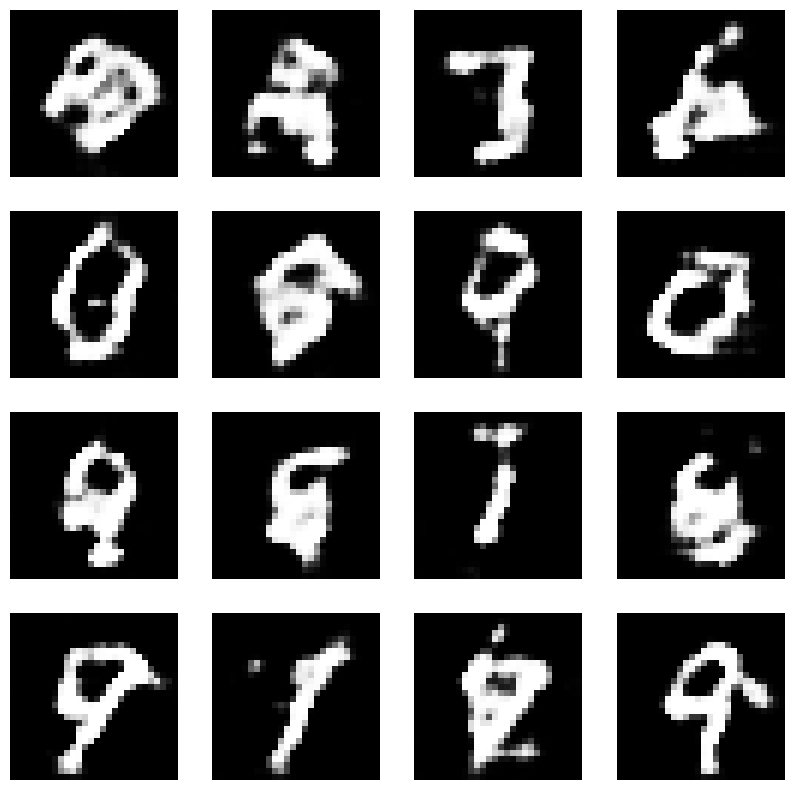

Época: 57


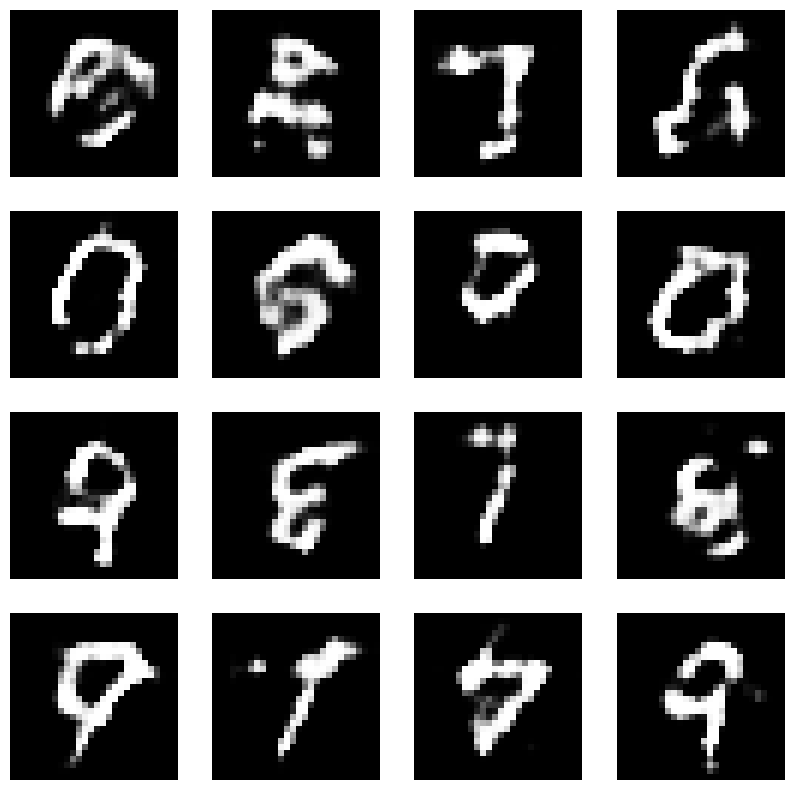

Época: 58


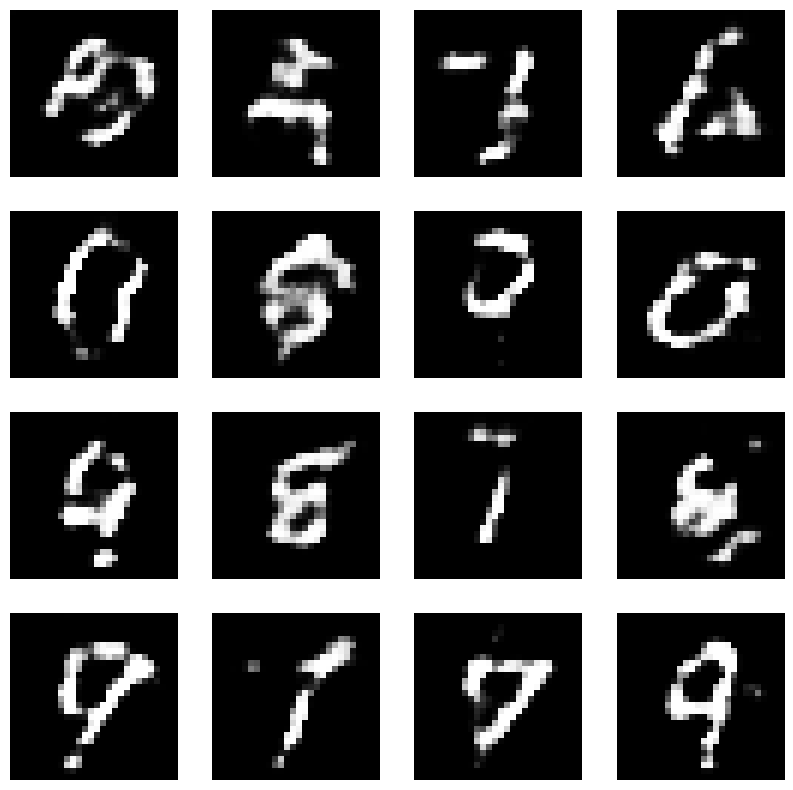

Época: 59


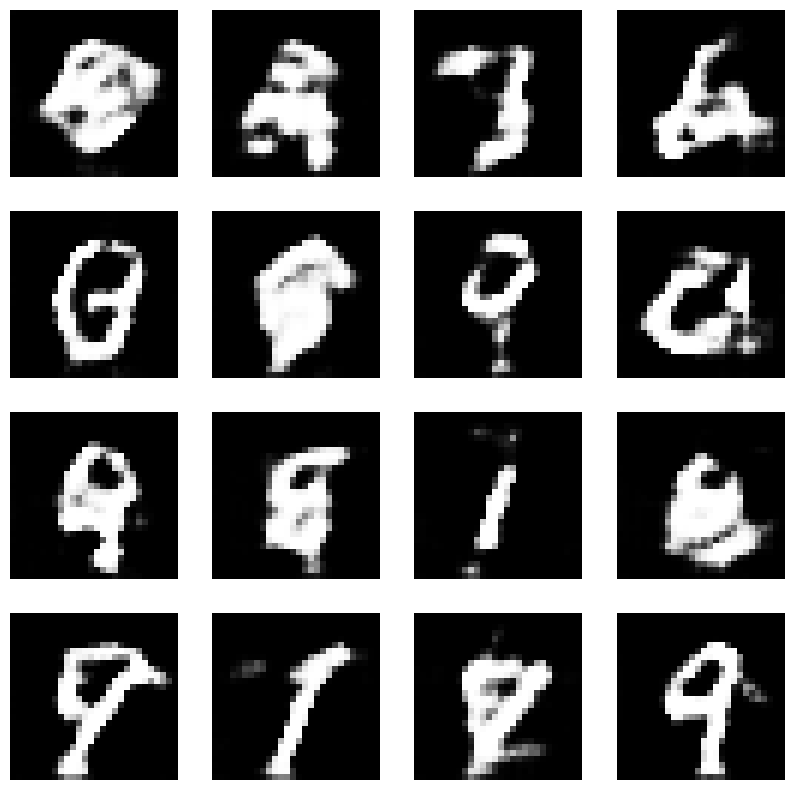

Época: 60


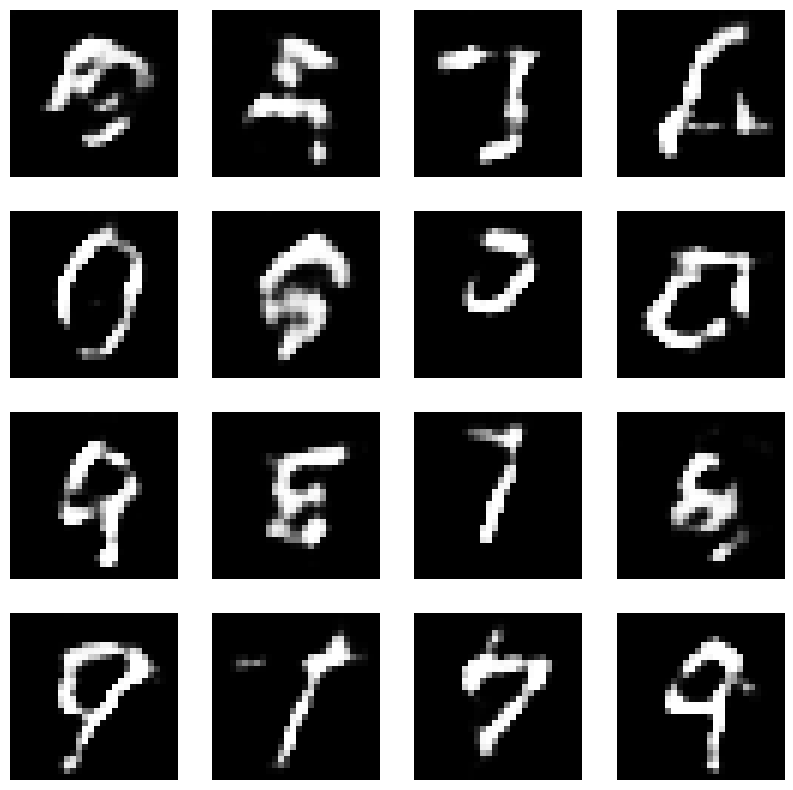

Época: 61


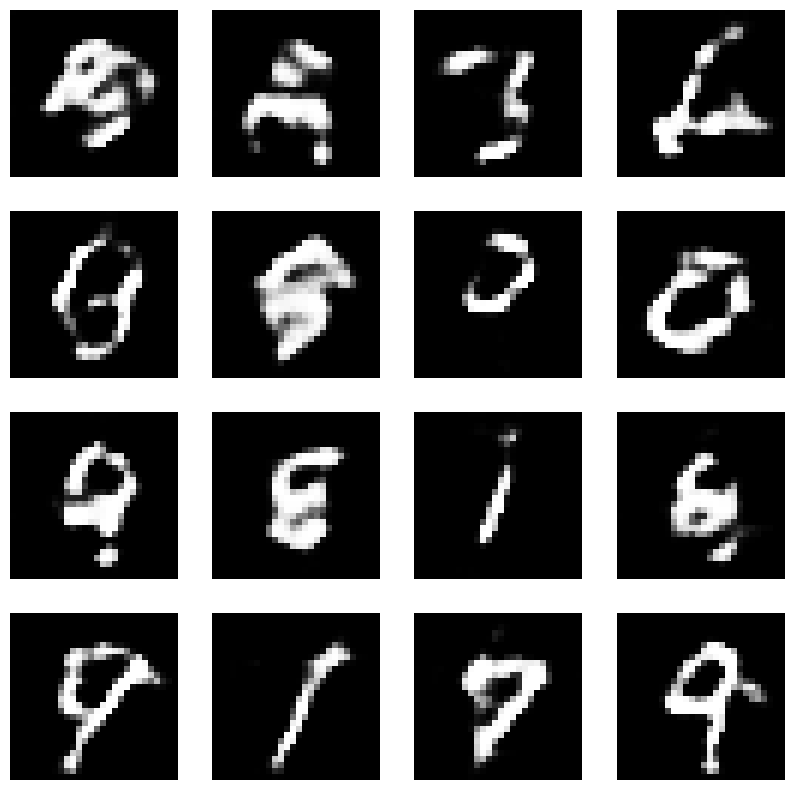

Época: 62


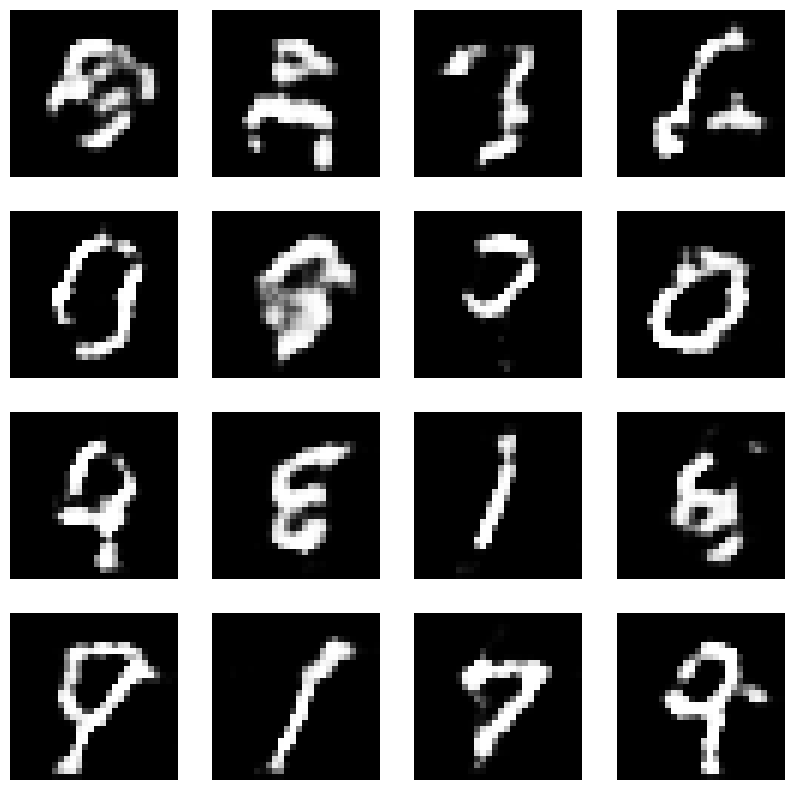

Época: 63


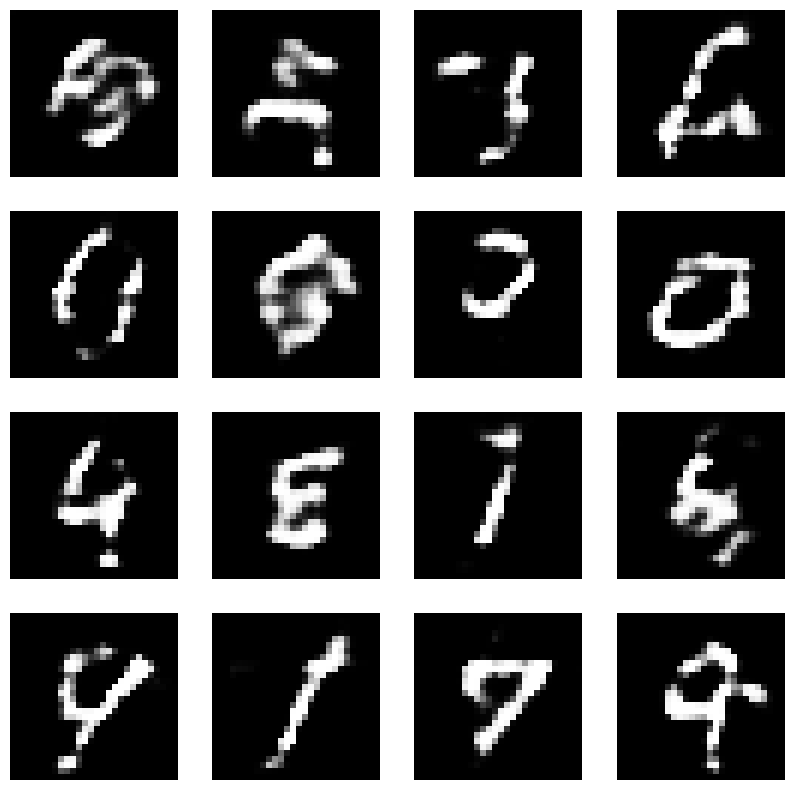

Época: 64


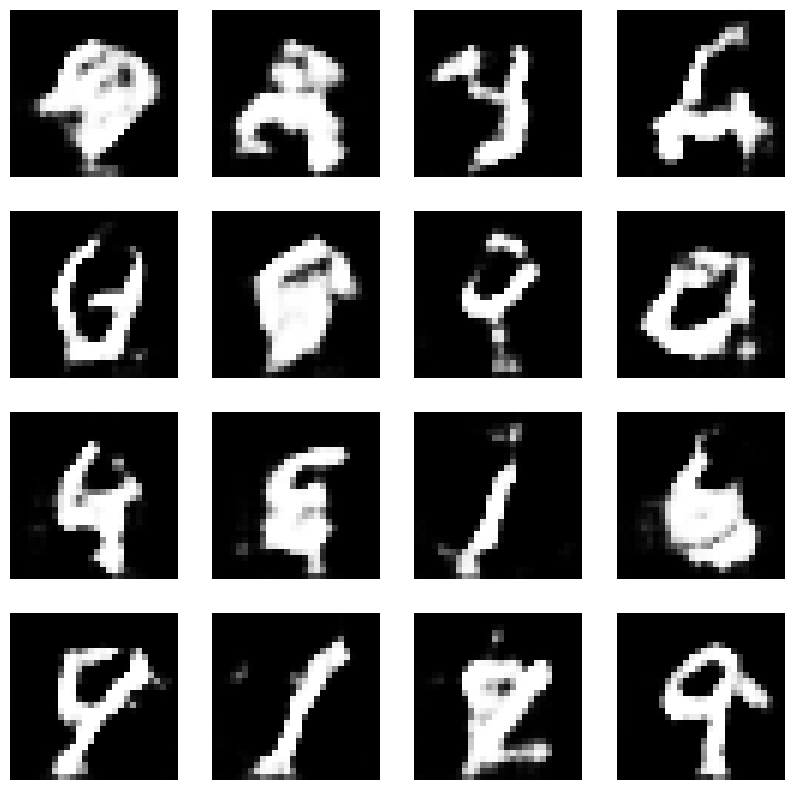

Época: 65


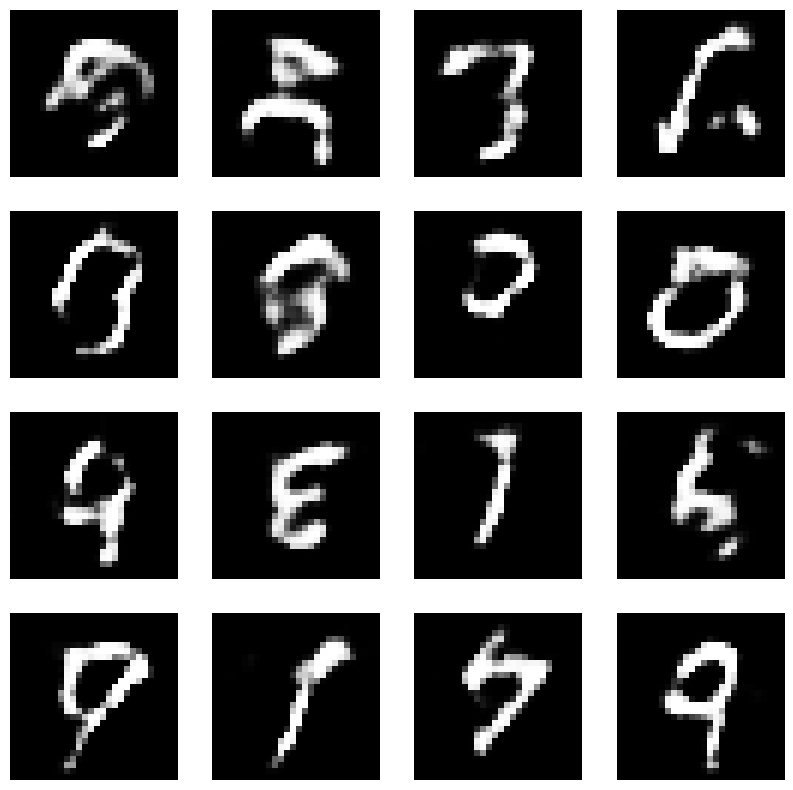

Época: 66


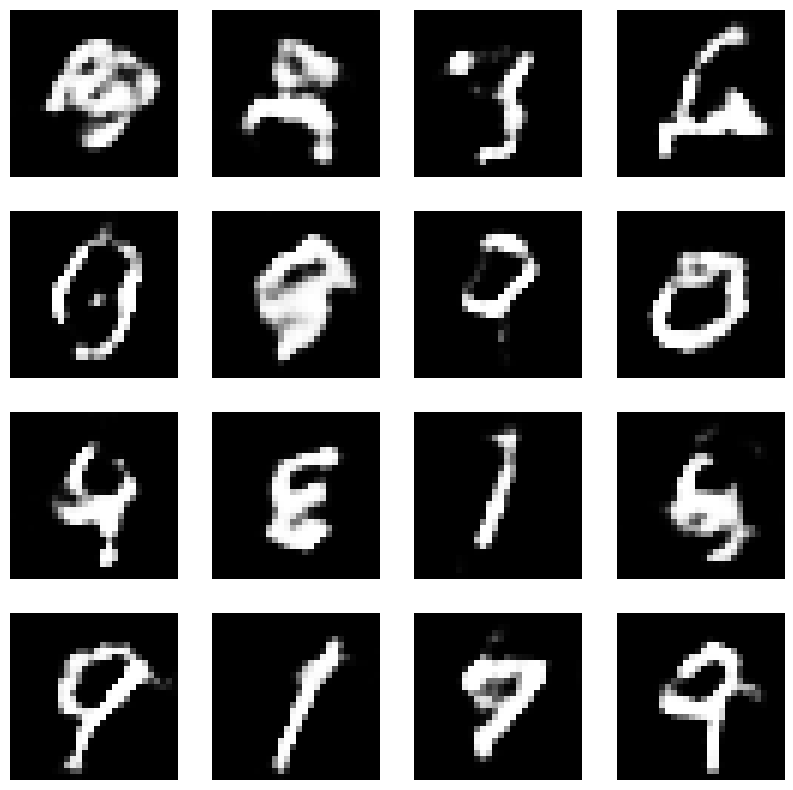

Época: 67


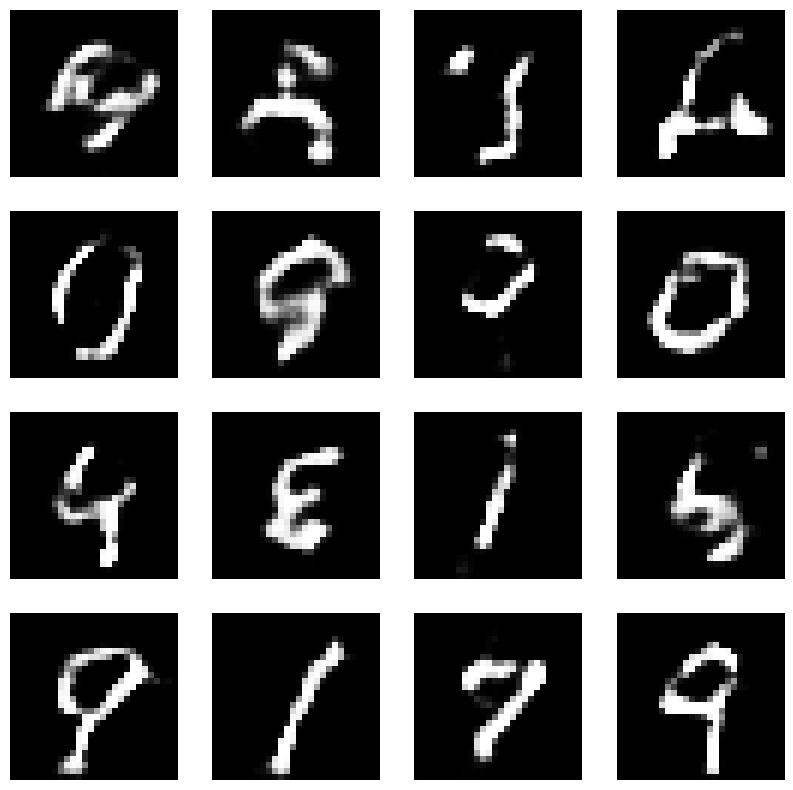

Época: 68


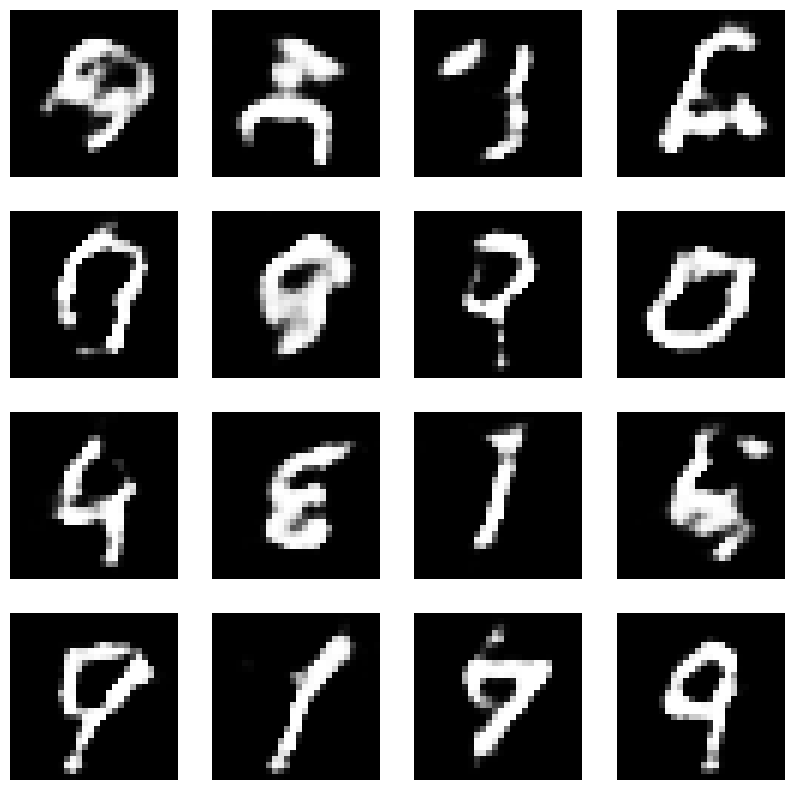

Época: 69


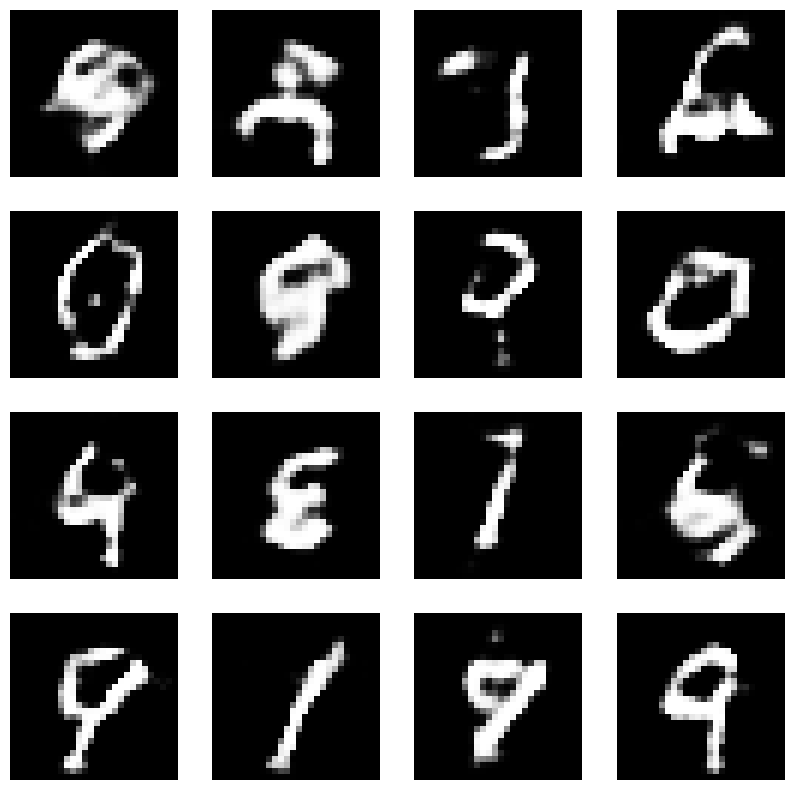

Época: 70


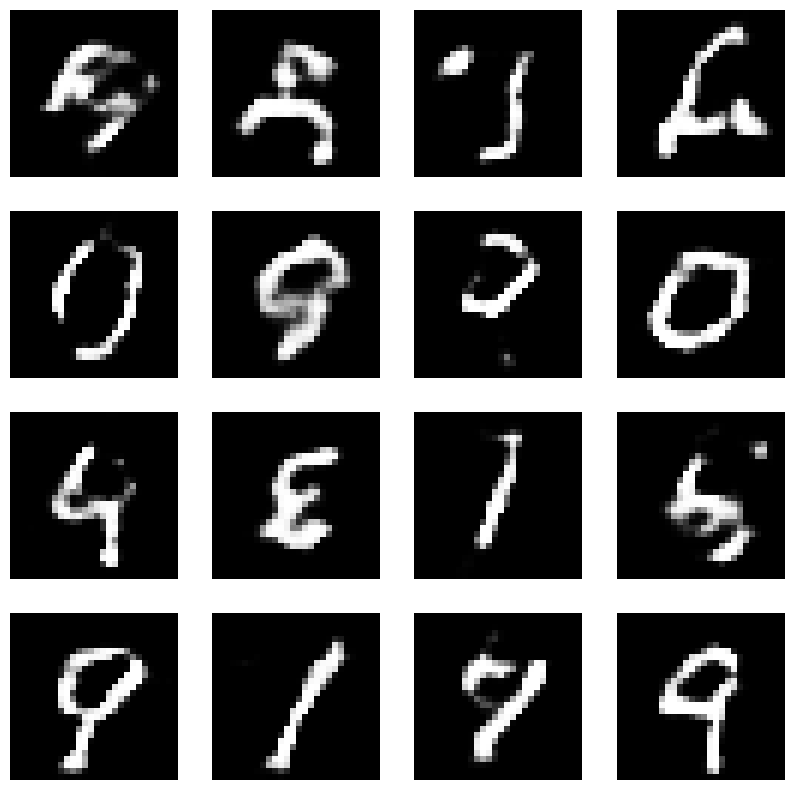

Época: 71


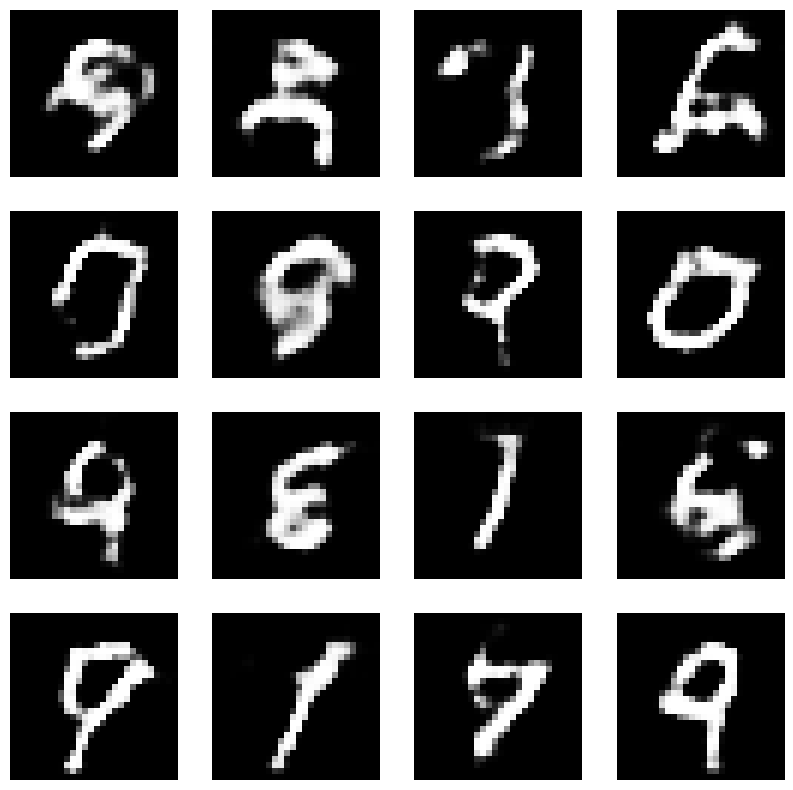

Época: 72


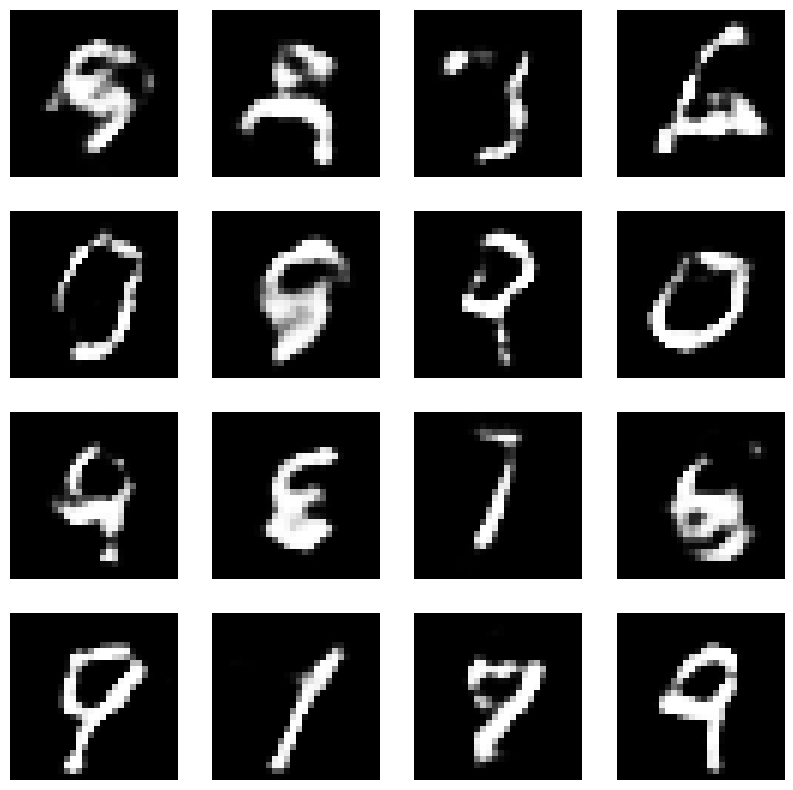

Época: 73


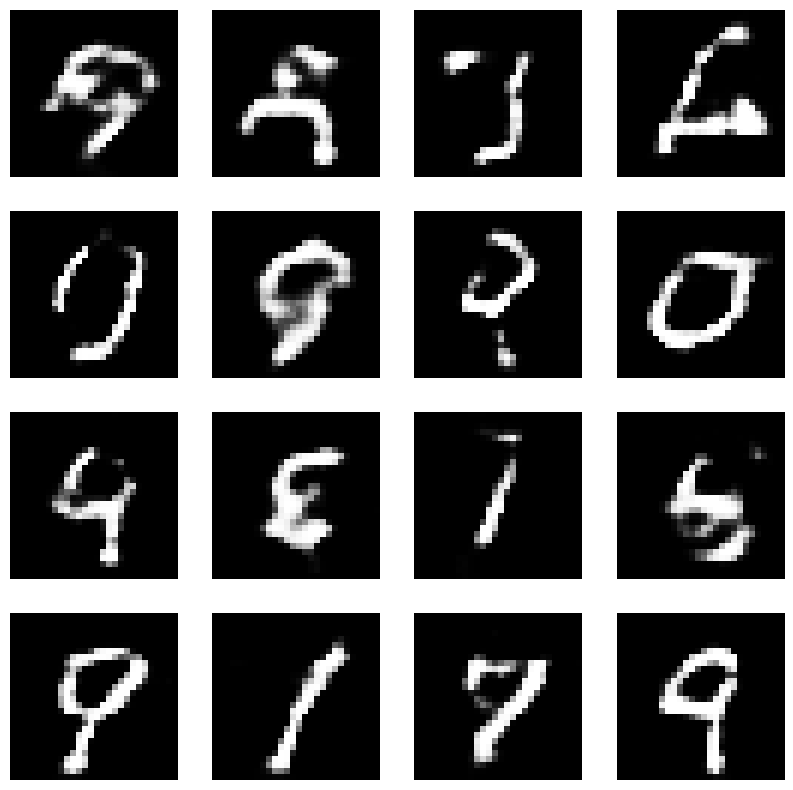

Época: 74


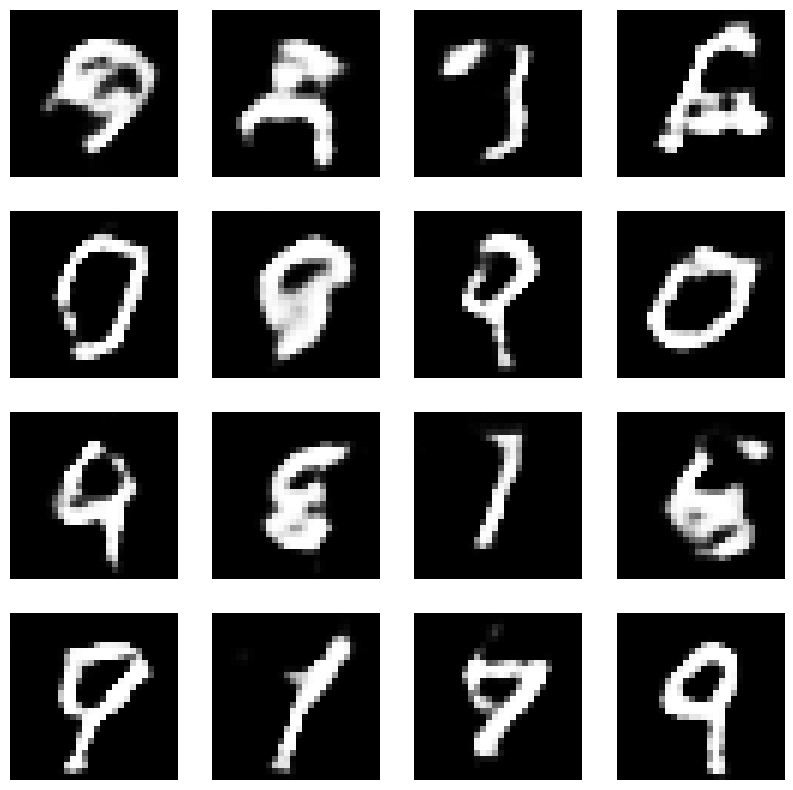

Época: 75


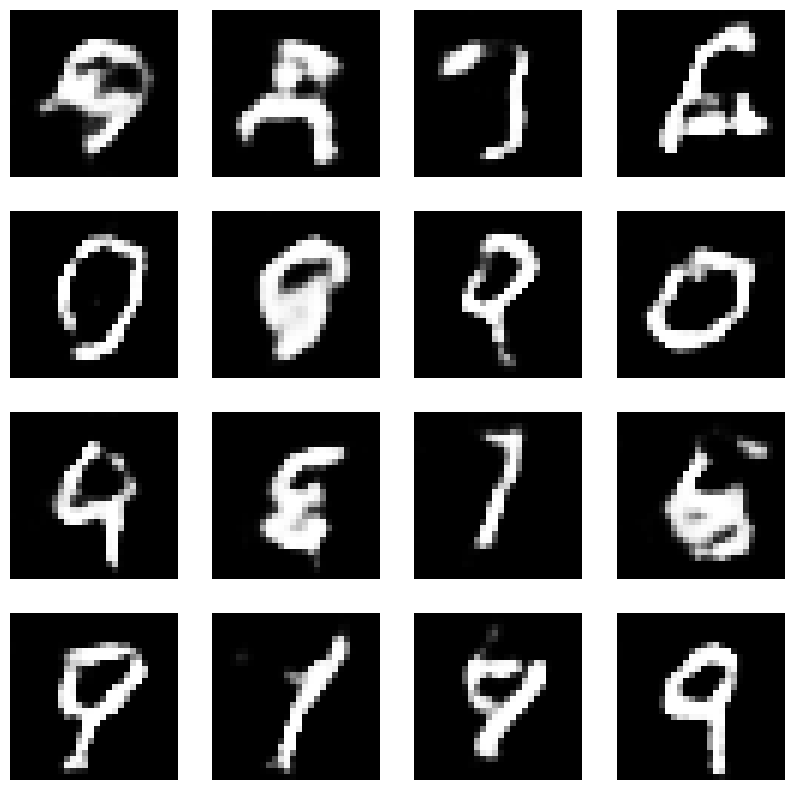

Época: 76


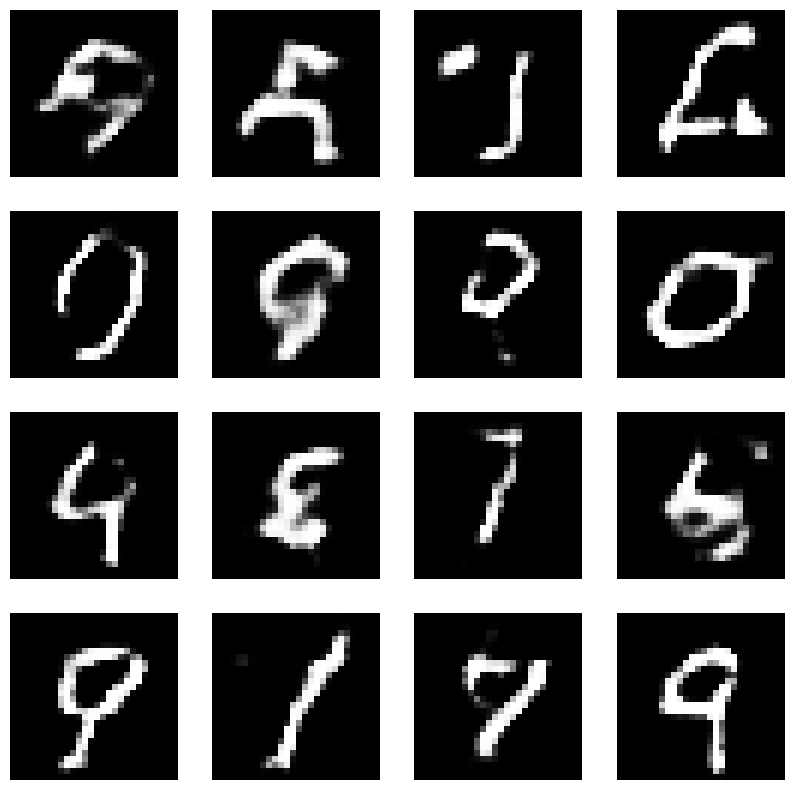

Época: 77


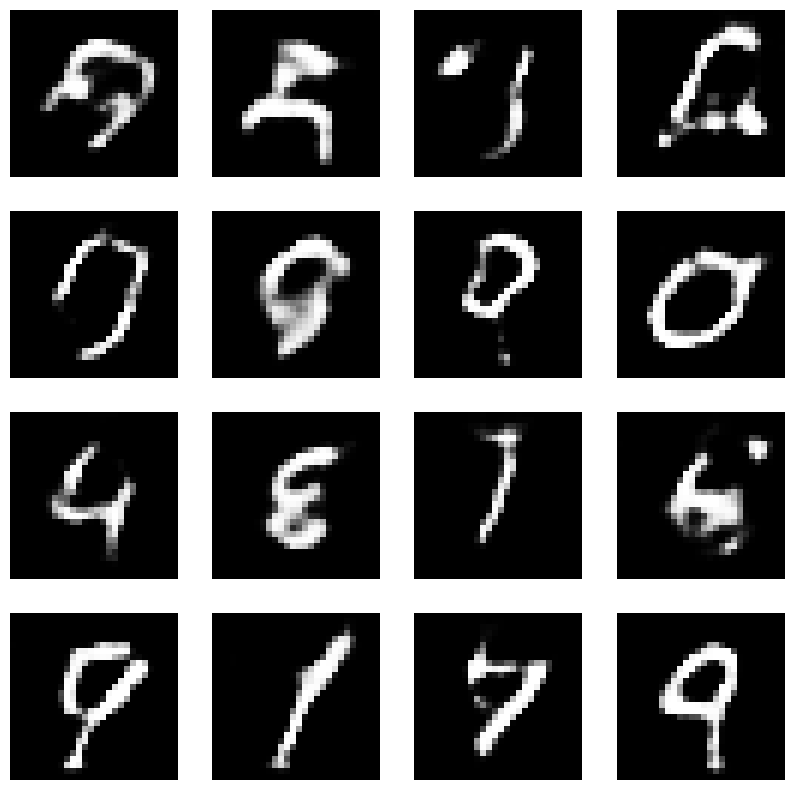

Época: 78


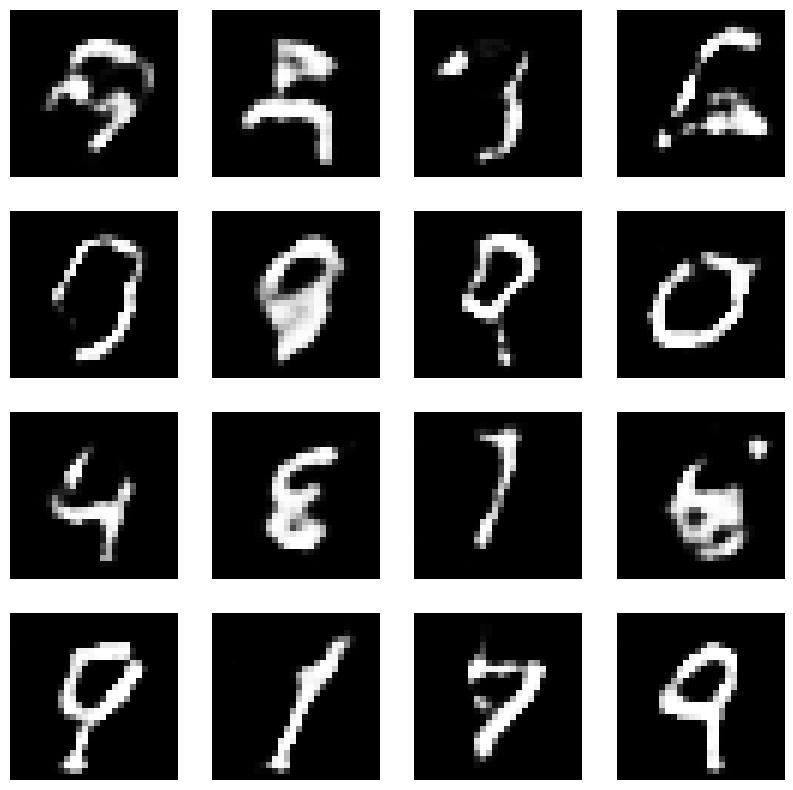

Época: 79


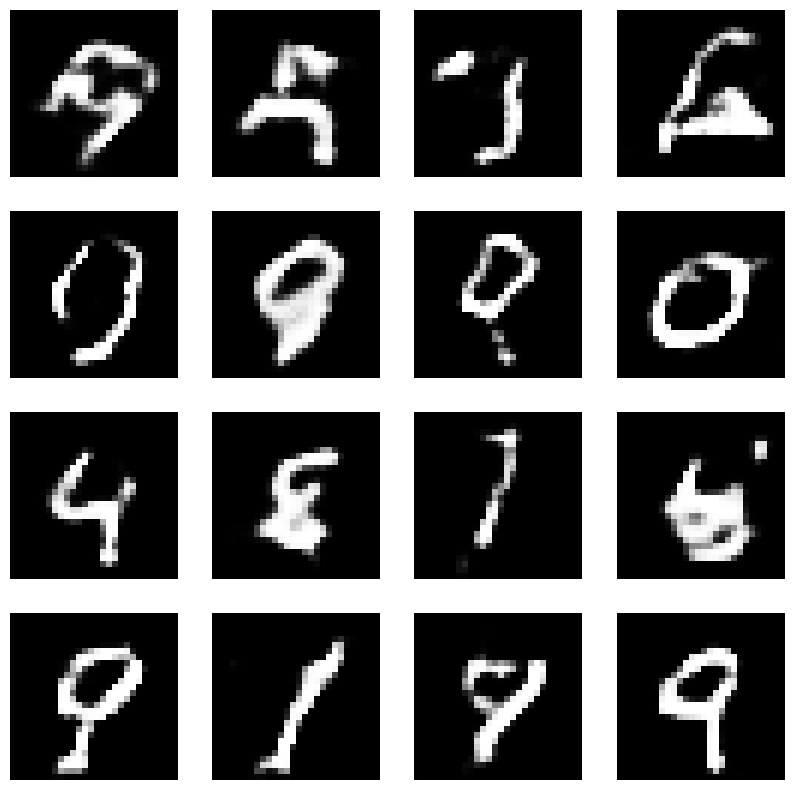

Época: 80


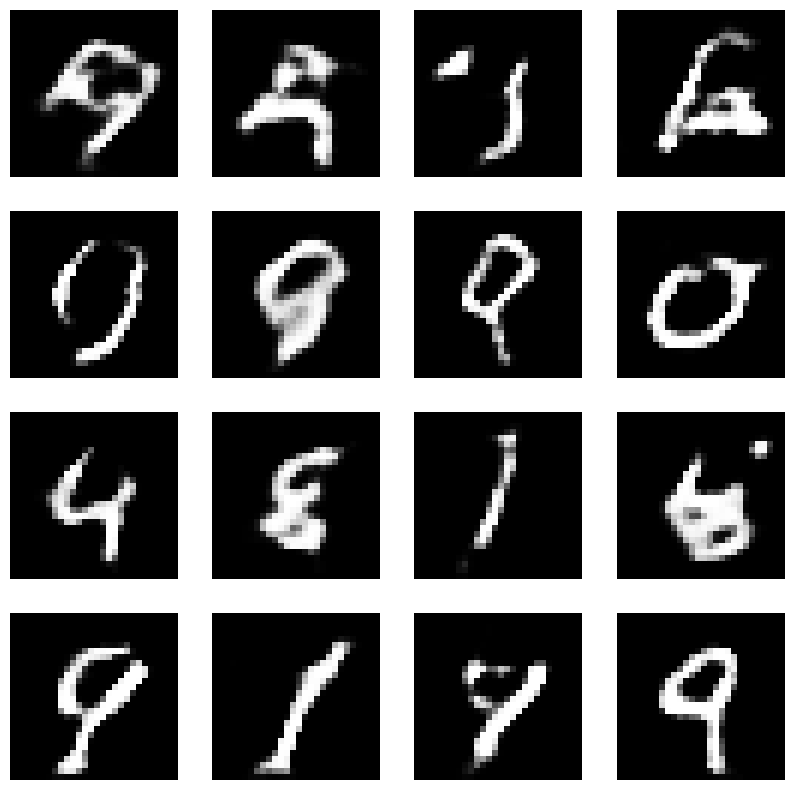

Época: 81


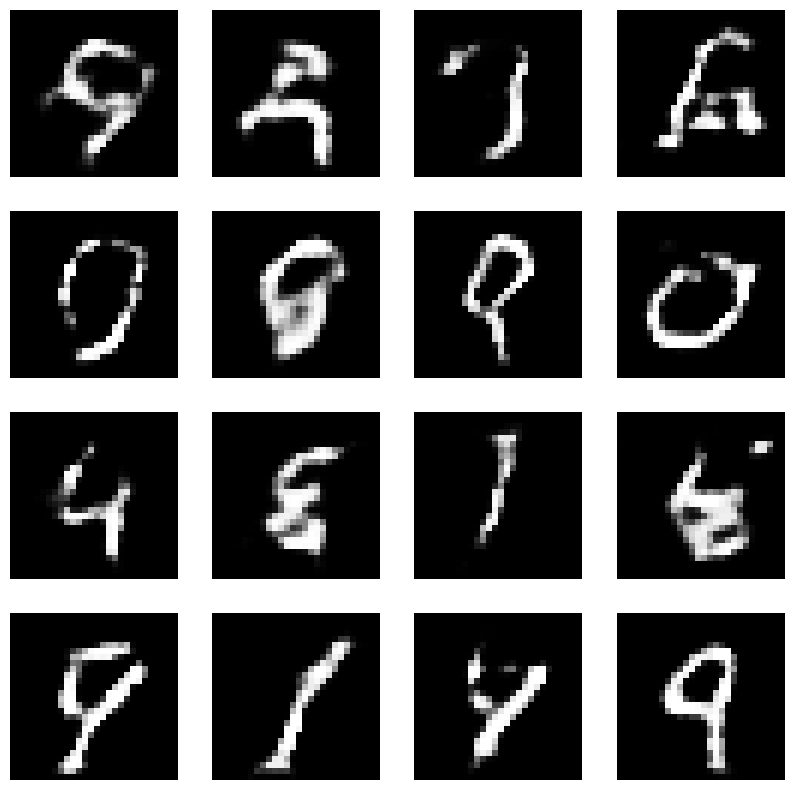

Época: 82


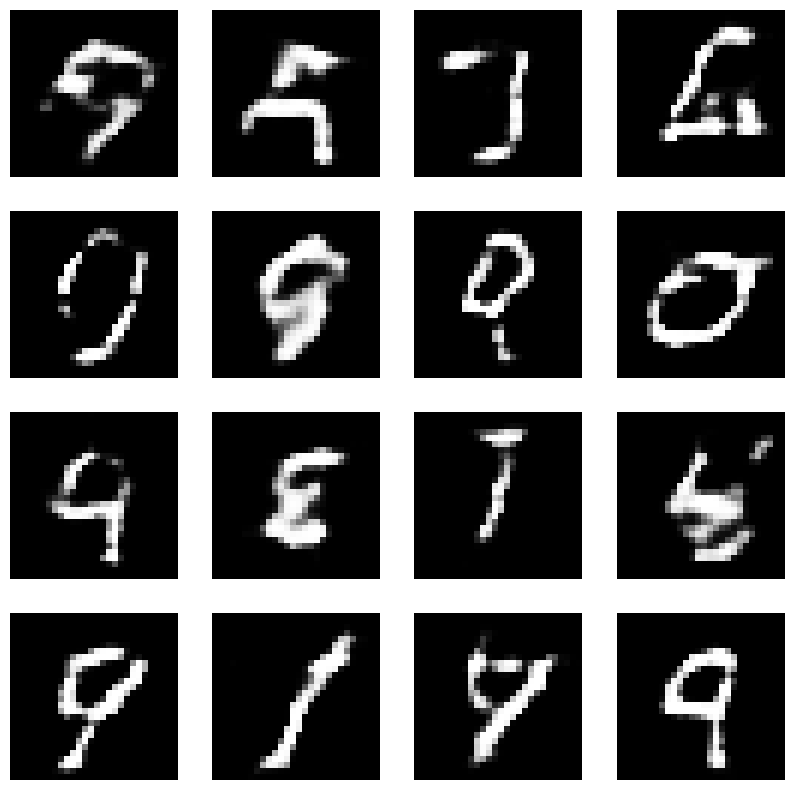

Época: 83


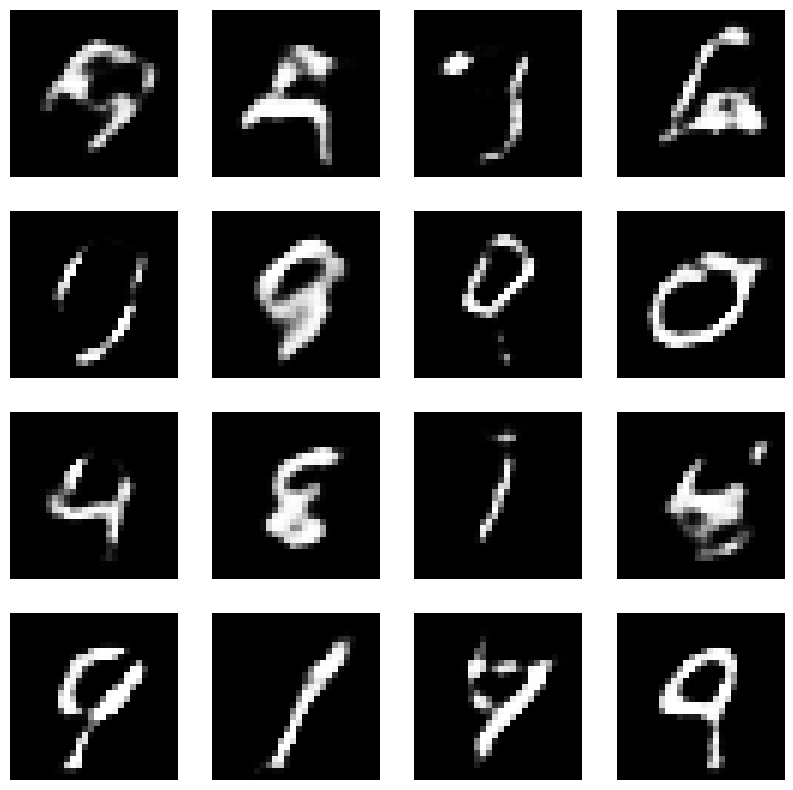

Época: 84


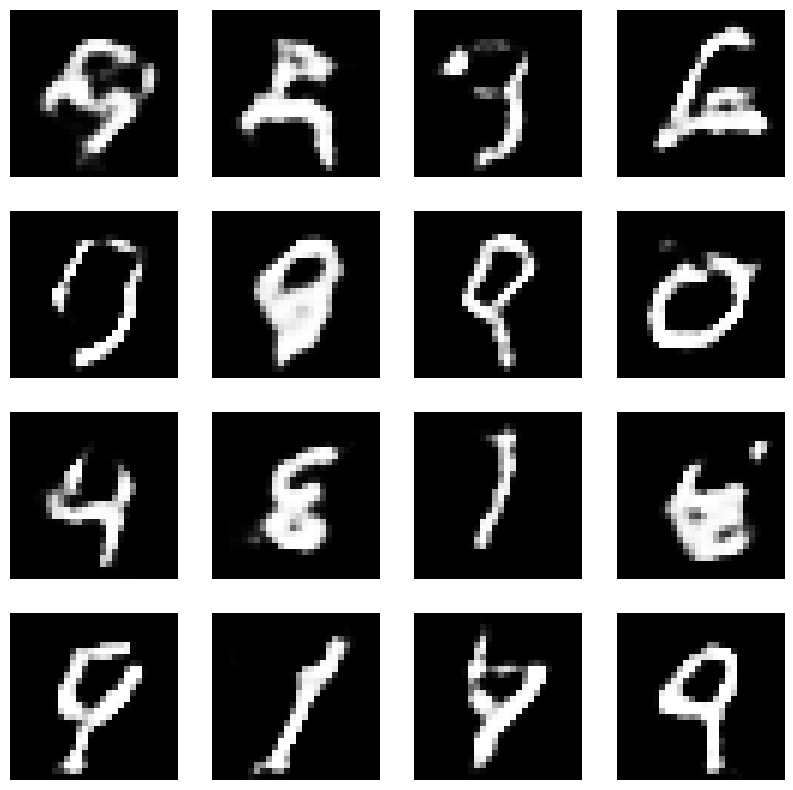

Época: 85


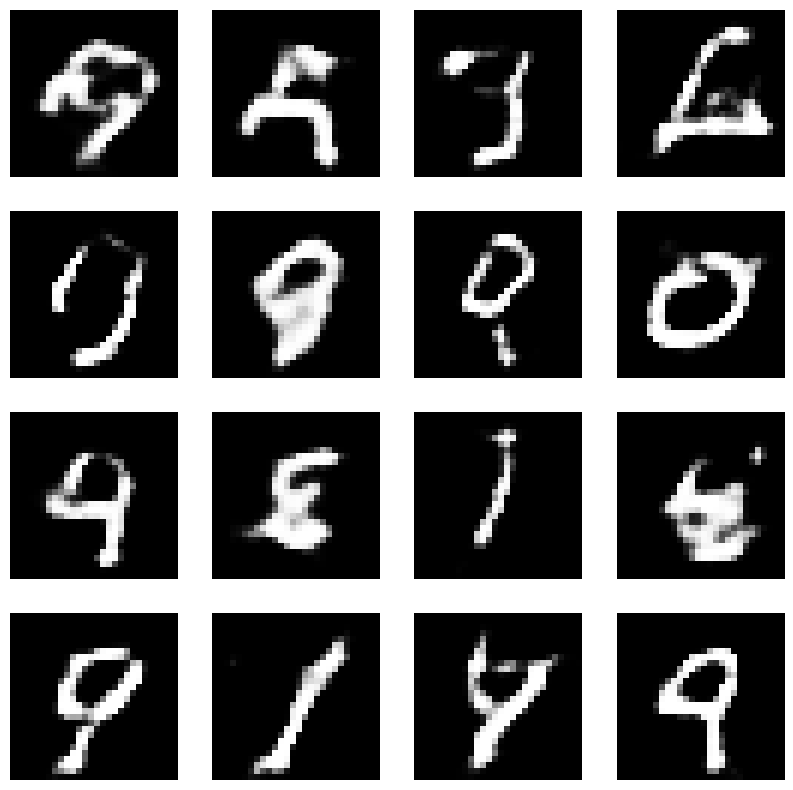

Época: 86


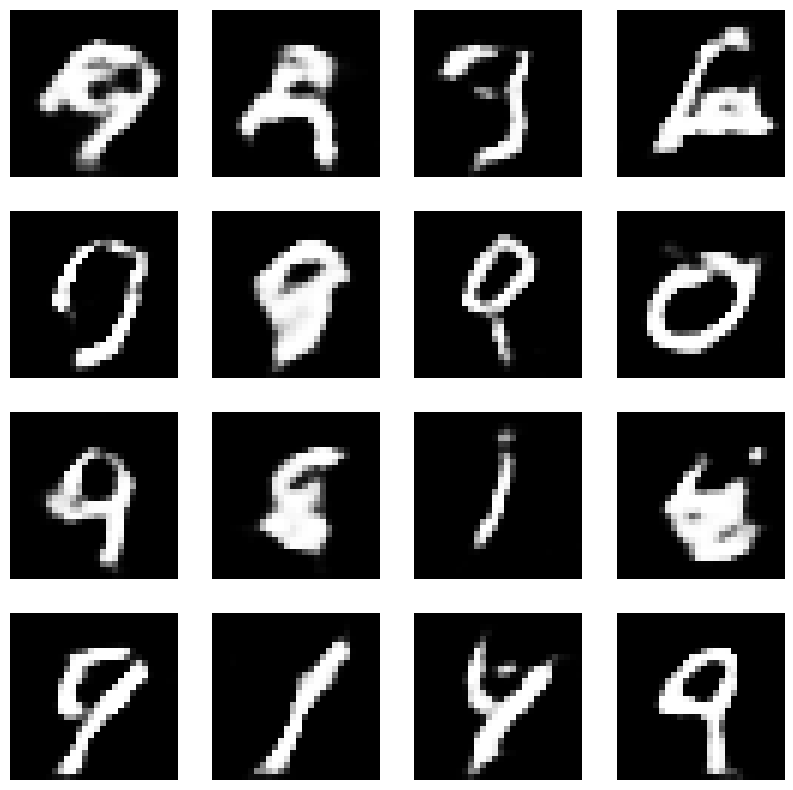

Época: 87


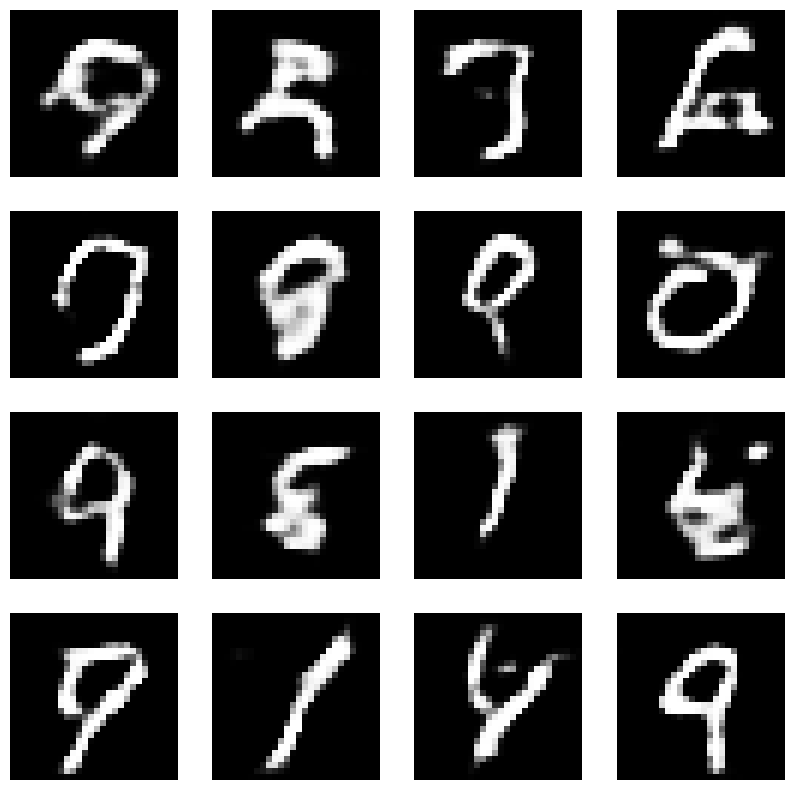

Época: 88


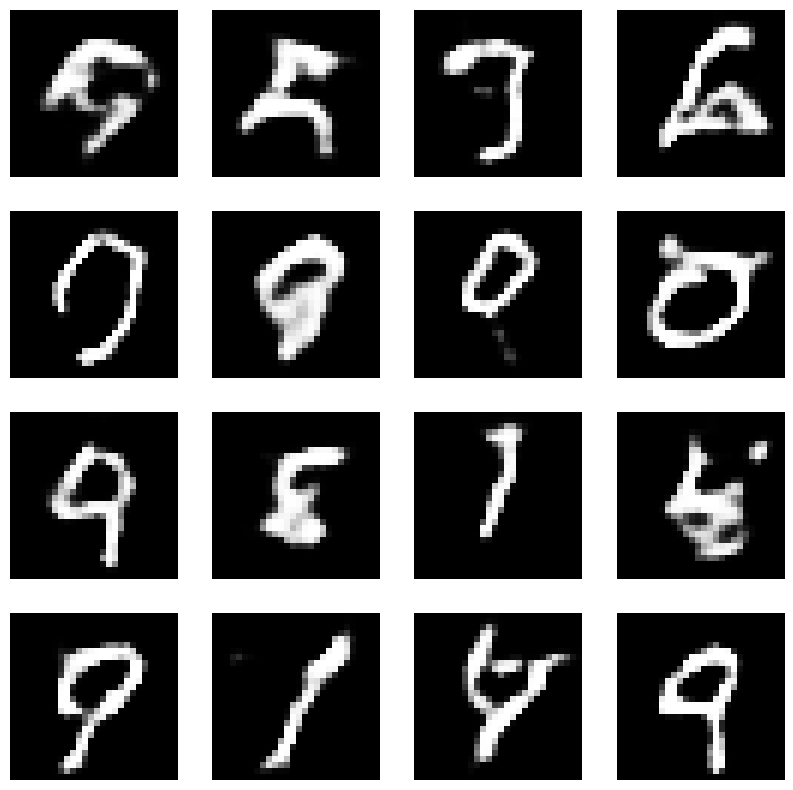

Época: 89


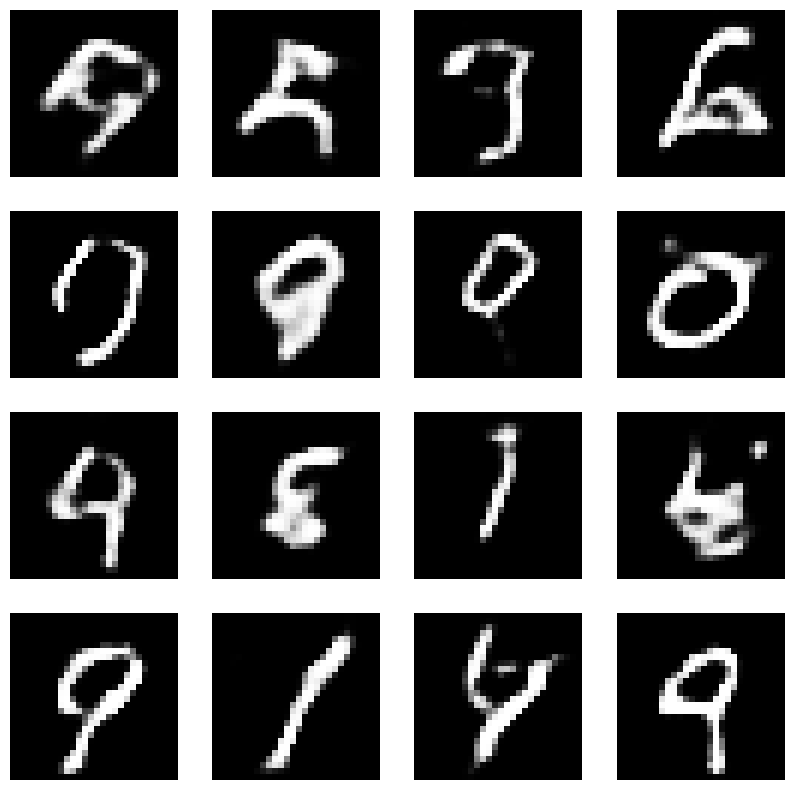

Época: 90


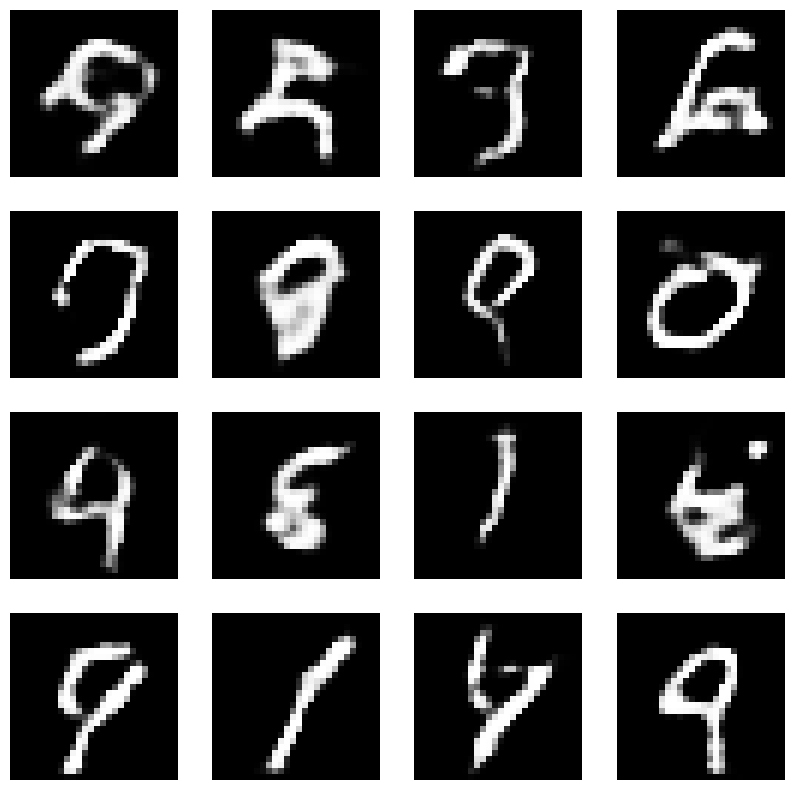

Época: 91


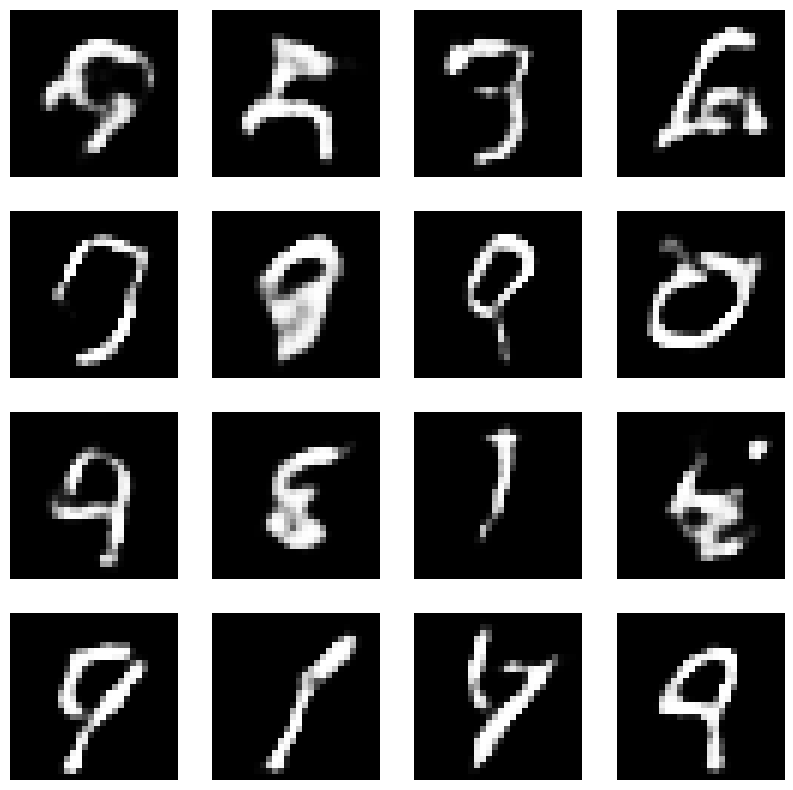

Época: 92


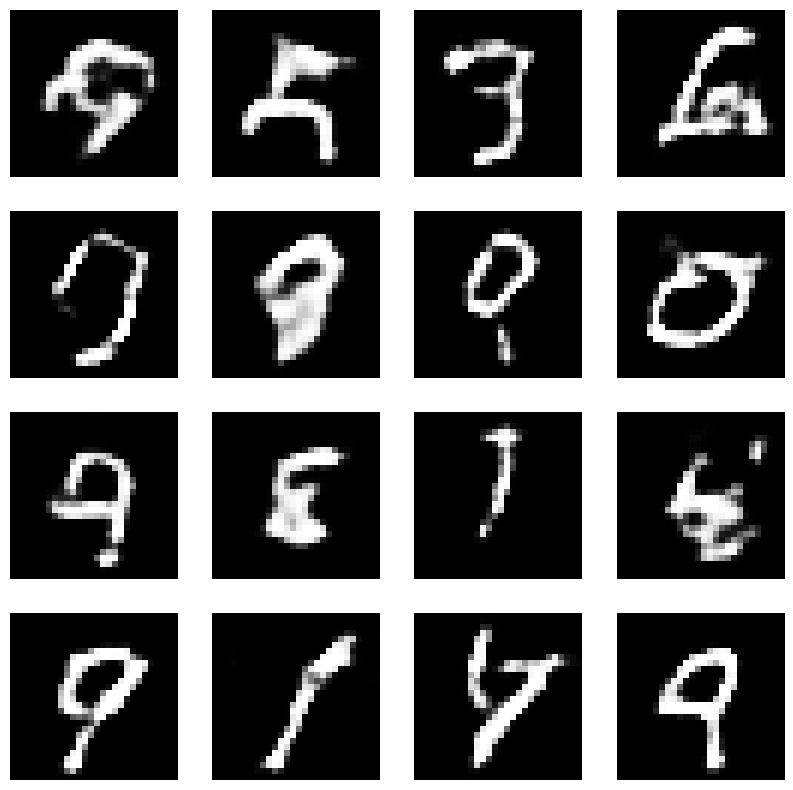

Época: 93


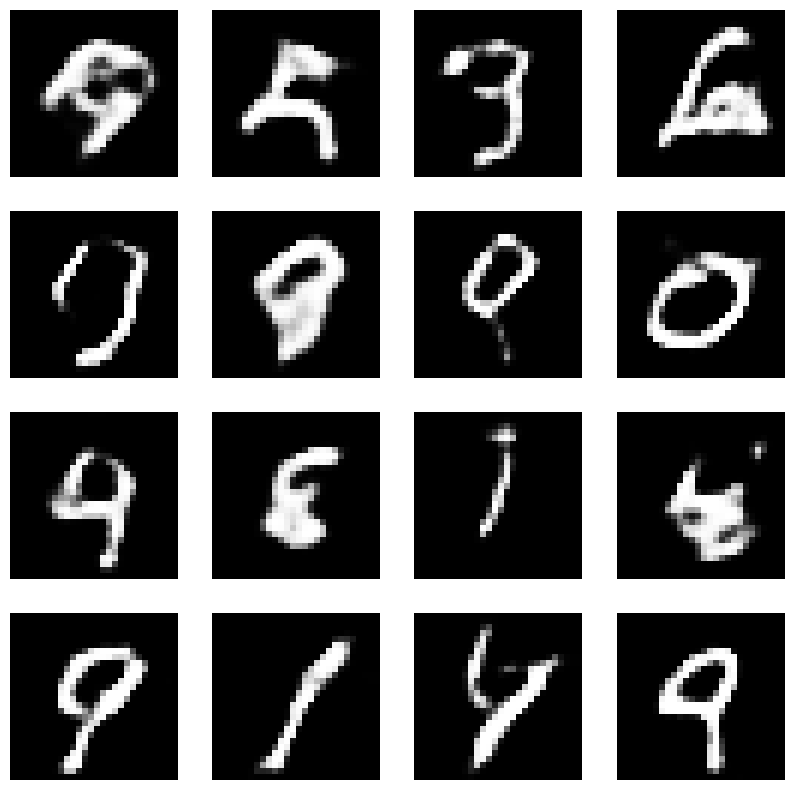

Época: 94


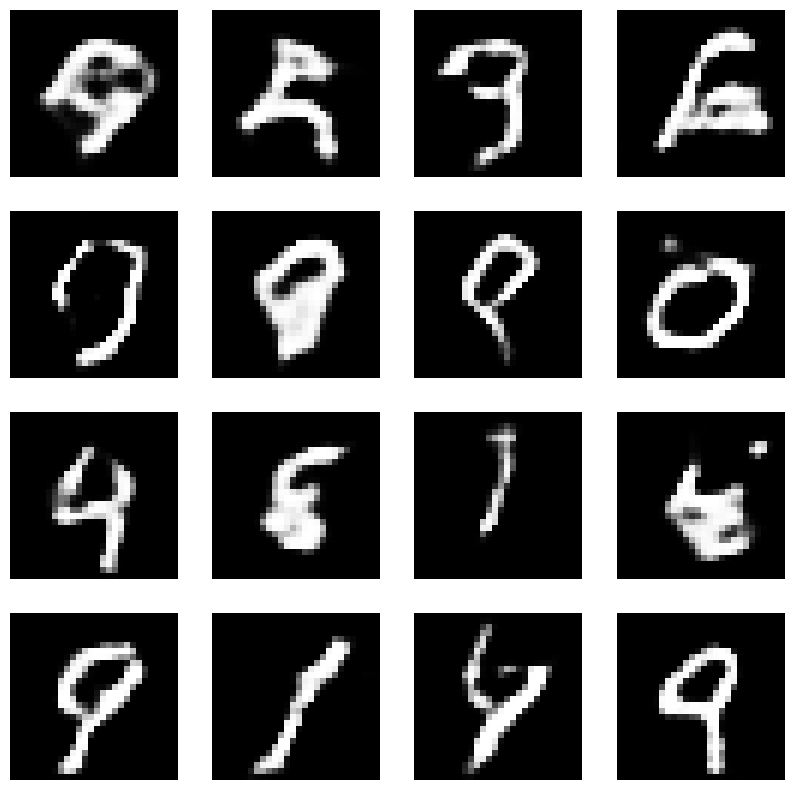

Época: 95


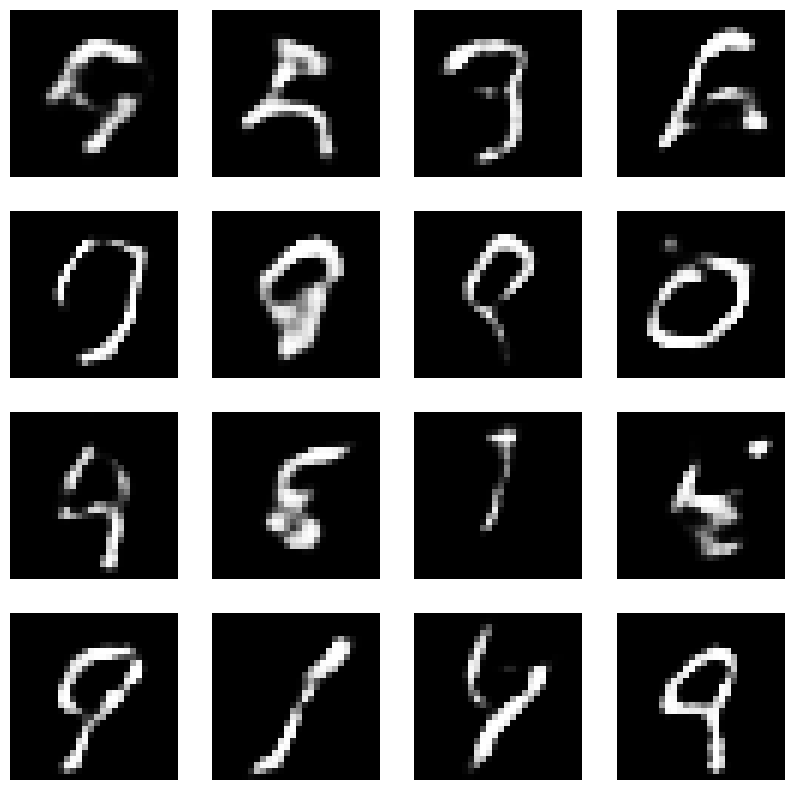

Época: 96


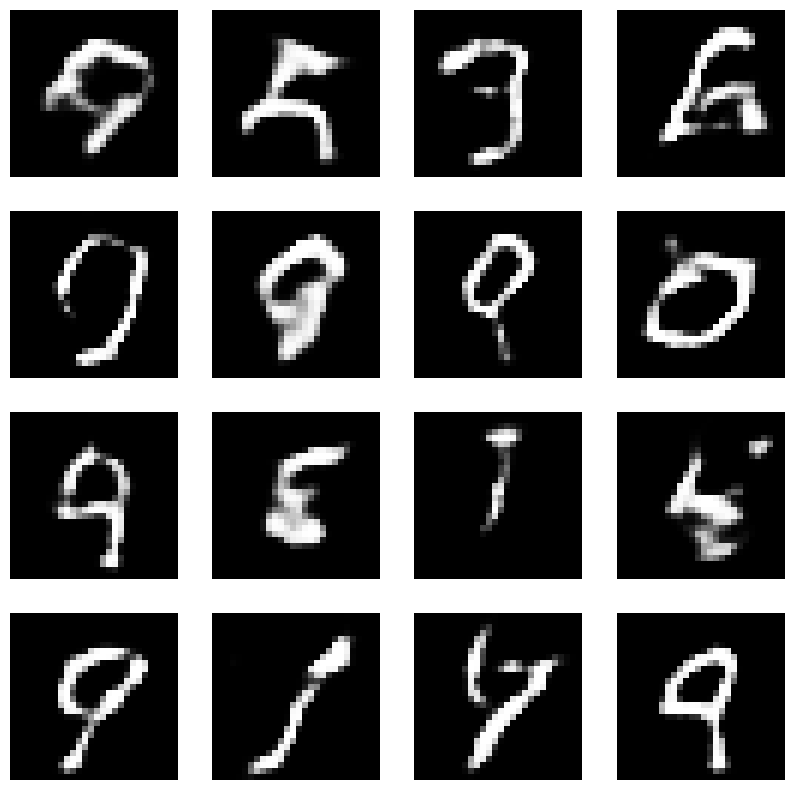

Época: 97


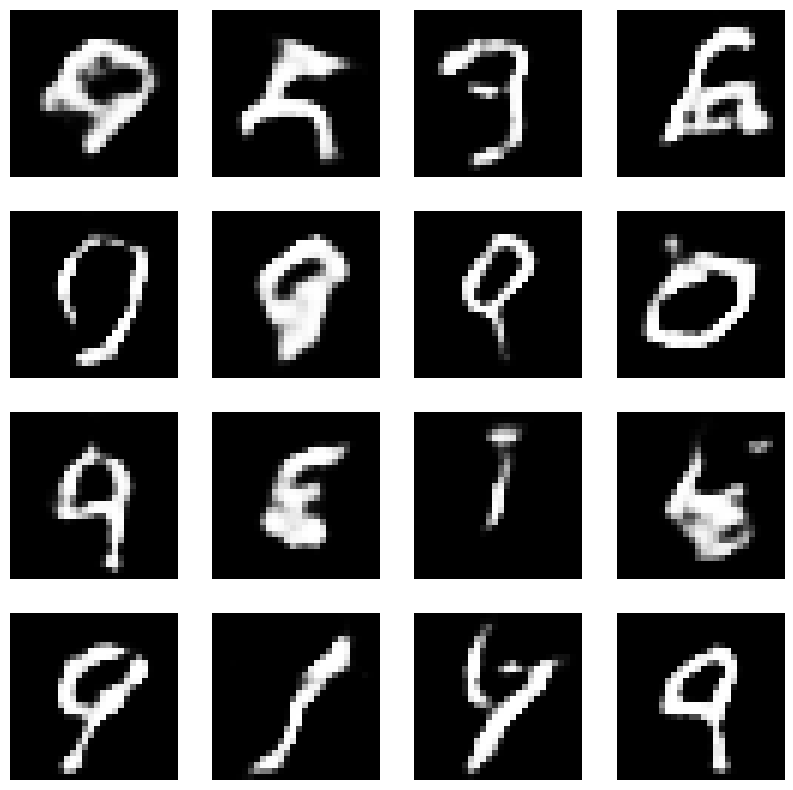

Época: 98


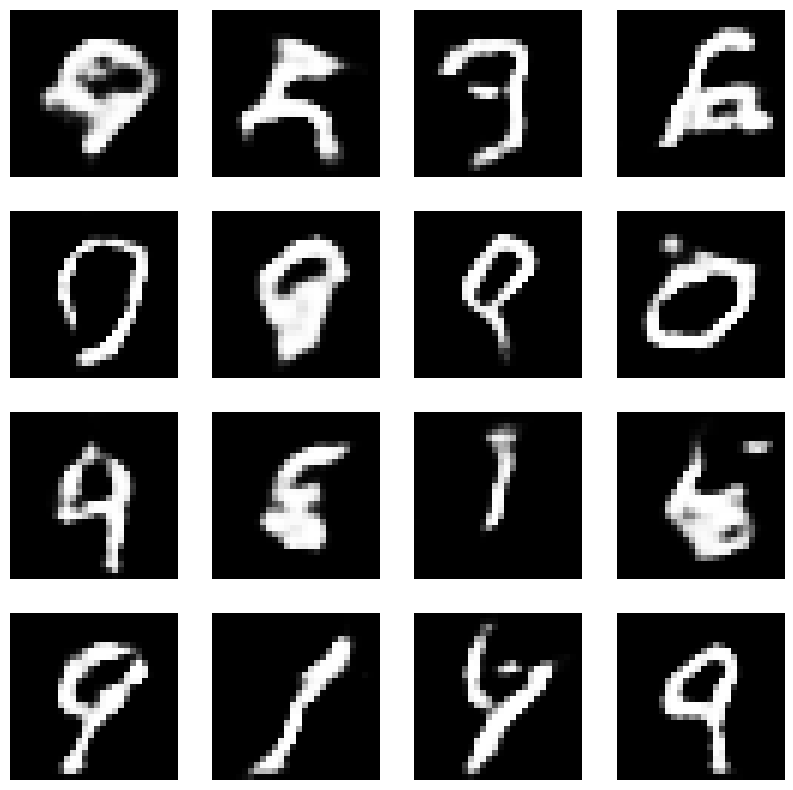

Época: 99


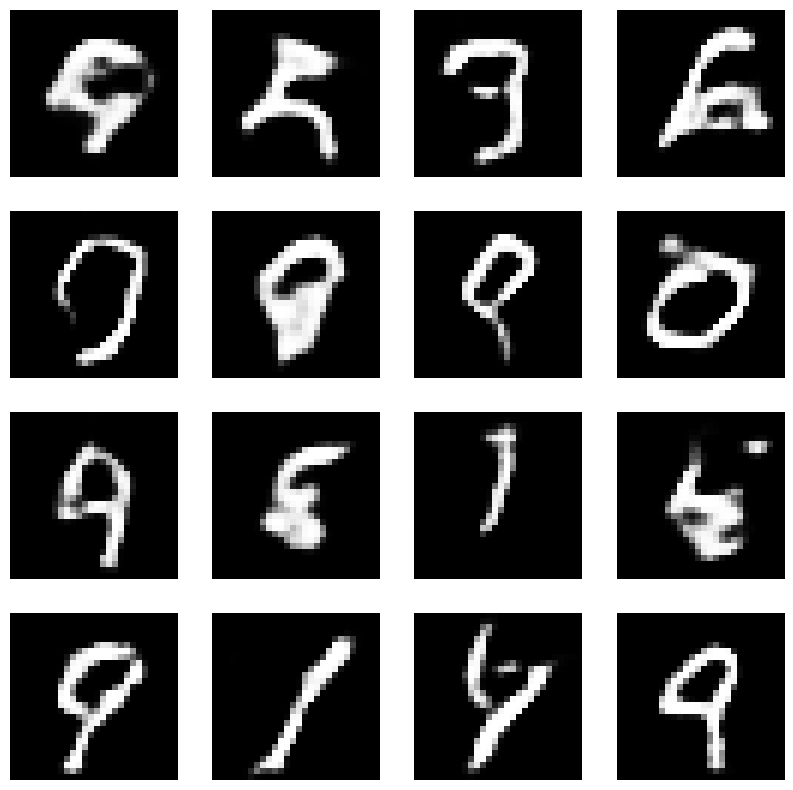

Época: 100


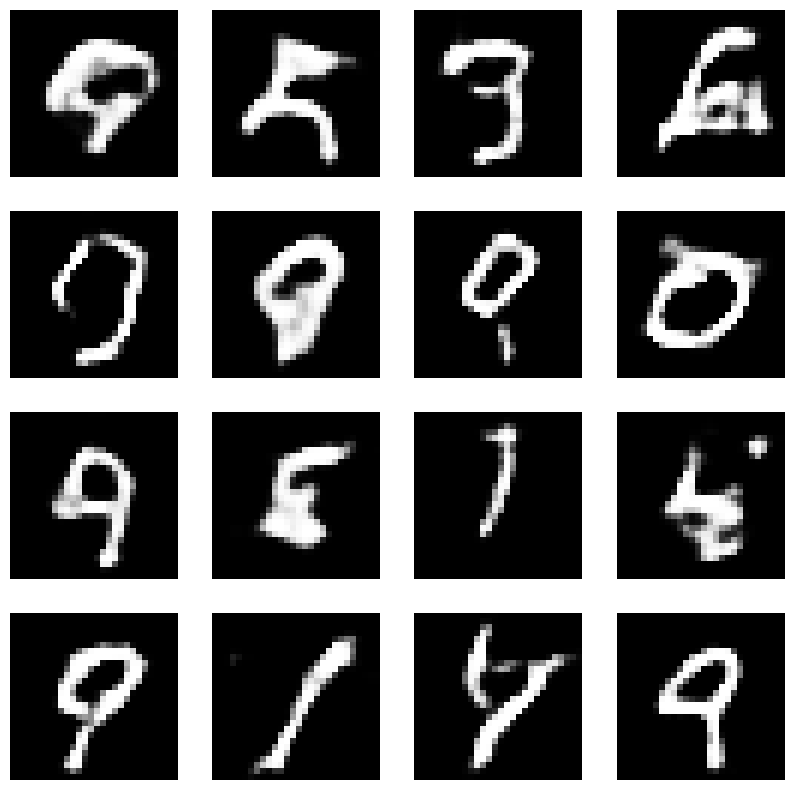

In [ ]:
treina_gan(X_treinamento, epocas, imagens_teste)